# Импорт библиотек и определение констант

In [1]:
import json
import re

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import xgboost as xgb
from catboost import CatBoostRegressor
from category_encoders import BinaryEncoder
from IPython.display import display
from sklearn.ensemble import (AdaBoostRegressor, ExtraTreesRegressor,
                              RandomForestRegressor, StackingRegressor)
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline 


RANDOM_SEED = 42
PRICE_CORRECTION = 0.80 # коррекция цены для датасета от 2021 года
VAL_SIZE= 0.2 # размер валидационной выборки

# Загрузка данных и первый обзор

In [2]:
# датасет из base_line
train_basic = pd.read_csv("./all_auto_ru_09_09_2020.csv")
# датасет, найденный на кагл
train_extra = pd.read_csv("./train_df_full.csv")
# тестовый датасет
test = pd.read_csv("./test.csv")
# датасет для сабминта на ЛБ
sample_submission = pd.read_csv("./sample_submission.csv")


In [3]:
# Посмотрим информацию по составу датасетов
print("\n" + "=" * 60 + " train_basic")
display(train_basic.info())
print("\n" + "=" * 60 + " train_extra")
display(train_extra.info())
print("\n" + "=" * 60 + " test")
display(test.info())


============================================================ train_basic
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 

None


============================================================ train_extra
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130201 entries, 0 to 130200
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              129986 non-null  object 
 1   brand                 129988 non-null  object 
 2   car_url               129969 non-null  object 
 3   color                 129988 non-null  object 
 4   complectation_dict    105267 non-null  object 
 5   description           129988 non-null  object 
 6   engineDisplacement    129988 non-null  object 
 7   enginePower           129988 non-null  object 
 8   equipment_dict        129969 non-null  object 
 9   fuelType              129986 non-null  object 
 10  image                 130065 non-null  object 
 11  mileage               103034 non-null  float64
 12  modelDate             129986 non-null  float64
 13  model_info            0 non-nu

None


============================================================ test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name         

None

In [4]:
# Визуально посмотрим на данные в каждом датасете
display(train_basic.head(3))
display(train_extra.head(3))
display(test.head(3))

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,Владение,ПТС,Привод,Руль,Состояние,Таможня,views,date_added,region,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"['cruise-control', 'multi-wheel', 'xenon', 'he...",Автомобиль приобретался у официального дилера ...,1.8 LTR,180 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,76.0,24 сентября,в Тюмени,999000.0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",Группа компаний Элан Моторс официальный дилер ...,1.6 LTR,110 N12,"{'cruise-control': True, 'glonass': True, 'asr...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,259.0,24 сентября,в Санкт-Петербурге,1179000.0
2,лифтбек,SKODA,https://auto.ru/cars/new/group/skoda/rapid/217...,белый,"['cruise-control', 'heated-wash-system', 'airb...",Специальные предложения на автомобили в наличи...,1.6 LTR,90 N12,"{'cruise-control': True, 'glonass': True, 'esp...",бензин,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1464100.0


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [5]:
# Видно, что в "train_basic" "Комплектация" это "complectation_dict", и "model" это "model_name". Переименуем
train_basic.rename(
    columns={
        "Комплектация": "complectation_dict",
        "model": "model_name",
    },
    inplace=True,
)

# Используемые функции

In [6]:
def describe_column(df, column):
    """
    Описание колонки: тип данных, пропуски, разбивка пропусков по датасетам
    """
    total = len(df[column])
    nan_count = len(df[df[column].isnull()][column])
    nan_count_df0 = len(df[(df[column].isnull()) & (df.data_type == 0)][column])
    nan_count_df1 = len(df[(df[column].isnull()) & (df.data_type == 1)][column])
    nan_count_df2 = len(df[(df[column].isnull()) & (df.data_type == 2)][column])
    print(f"{'data type':>20}: {str(df[column].dtype)}")
    unique = len(df[column].unique())
    print(f"{'unique values':>20}: {unique}")
    print(f"{'total':>20}: {total}")
    print(
        f"{column+' nan':>20}: {round(nan_count/total*100,1)}% = {nan_count}\
        ({nan_count_df0}/{nan_count_df1}/{nan_count_df2})"
    )
    df[column].value_counts()
    if len(df[column].unique()) < 11:
        display(df[column].value_counts())


def map_rus_to_eng(value, dict_):
    """
    Замена значений по словарю, использовалась для перевод в английский
    """
    if value is np.nan:
        return np.nan
    if value in list(dict_.values()):
        return value
    return dict_.get(value, np.nan)


def fill_from_groupped_series(groupped_series, brand, model_name, default_value):
    """
    Для заполнения пропусков с учетом группировки по брендам/моделям
    """
    try:
        result = groupped_series[brand][model_name].index[0]
    except:
        result = default_value
    return result


def var_name(obj):
    """
    Возвращает имя переменной
    """
    return [name for name in globals() if globals()[name] is obj]


def print_collums_diff(df1, df2):
    """
    Сравнение двух датасетов с точки зрения колонок
    """
    print(f"Колонки есть в '{var_name(df1)[0]}', но нет в '{var_name(df2)[0]}':")
    print("\t", ", ".join(set(df1.columns).difference(set(df2.columns))))
    print(f"Колонки есть в '{var_name(df2)[0]}', но нет в '{var_name(df1)[0]}':")
    print("\t", ", ".join(set(df2.columns).difference(set(df1.columns))))


def text_to_json(value):
    """
    Преобразование словаря из строки в json
    """
    if value is np.nan:
        return np.nan

    if not isinstance(value, str):
        return np.nan

    if value[1] == "'":
        value = value.replace("'", '"')
    value = value.lower()

    try:
        result = json.loads(value)
    except:
        return np.nan

    return result


def equipment_dict_to_set(value):
    """
    Преобразование колонки equipment в set
    """
    result = text_to_json(value)
    if result is np.nan:
        return set()

    if len(result) == 0:
        return set()

    return set(result.keys())


def complectation_dict_to_set(value):
    """
    Преобразование комплектации в set
    """
    result = text_to_json(value)

    if result is np.nan:
        return set()

    if len(result) == 0:
        return set()

    try:
        result = result["available_options"]
    except:
        return set()

    return set(result)


def format_engine_power(value):
    """
    Форматирование мощности двигателя.
    Если просто число или пропуск, так и оставляем, если это строка, то берем первый элемент
    """
    if value is np.nan:
        return np.nan
    if isinstance(value, float):
        return value
    if not isinstance(value, str):
        return np.nan
    power_value = value.split()[0]
    if power_value.isdigit():
        return int(power_value)
    else:
        return np.nan


def format_model_name(df, brand, column_name, old_str, new_str):
    """
    Форматирование имени модели по предоставленному словарю. Для замены спецсимволов, пробелов и прочее
    """
    df.loc[df.brand == brand, column_name] = df.loc[df.brand == brand, column_name].str.replace(
        old_str, new_str, regex=True
    )
    return True


def format_engine_displacement(value):
    """
    Поиск объема двигателя в строке
    """
    r = re.search(r"(\d+\.\d+)", str(value))
    if r:
        return float(r.group(1))
    return np.nan


def show_histogram(df, column, limit, bins=100):
    """
    Гистограмма параметра, со статистикой по выбросам и квартилям
    """
    fig, _ = plt.subplots(figsize=(15, 3))
    fig.patch.set_facecolor("xkcd:white")
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    per25 = df[column].quantile(0.25)
    per75 = df[column].quantile(0.75)
    l_out = per25 - 1.5 * iqr
    r_out = per75 + 1.5 * iqr
    print(f"max: {df[column].max()}")
    print(f"min: {df[column].min()}")
    print(f"med: {df[column].median()}")
    print(f"25 percentile: {per25}")
    print(f"75 percentile: {per75}")
    print(f"Outlier left: {l_out}")
    print(f"Outlier left count: {len(df[df[column]<l_out])}")
    print(f"Outlier right: {r_out}")
    print(f"Outlier right count: {len(df[df[column]>r_out])}")

    df[column].loc[df[column].between(per25 - 1.5 * iqr, per75 + 1.5 * iqr)].hist(
        bins=bins,
        range=(0, limit),
        label="Values",
    )
    df[column].loc[df[column] > r_out].hist(alpha=0.5, bins=bins, range=(0, limit), label="Right Outliers")
    df[column].loc[df[column] < l_out].hist(alpha=0.5, bins=bins, range=(0, limit), label="Left Outliers")
    plt.legend()


def mape(y_true: np.ndarray, y_pred: np.ndarray):
    """
    Расчет ошибки Mean Absolute Percentage Error
    """
    return np.mean(np.abs((y_pred - y_true) / y_true))


class SeabornFig2Grid:
    """
    Прорисовка двух sbn на одном графике, взят со stackoverflow
    """

    def __init__(self, seaborngrid, fig, subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n, m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i, j], self.subgrid[i, j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h = self.sg.ax_joint.get_position().height
        h2 = self.sg.ax_marg_x.get_position().height
        r = int(np.round(h / h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r + 1, r + 1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        ax.remove()
        ax.figure = self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


def kfold_validate(model, X, y, n_splits=4):
    """
    K-Fold валидация, возвращаем лист со списком всех МАРЕ + последний элемент равный среднему МАРЕ.
    Если n-splits=4, то будет 4 МАРЕ для каждой итерации + 1 средняя МАРЕ
    """
    skf = KFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=RANDOM_SEED,
    )

    mape_values = []

    for train_index, test_index in skf.split(X, y):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        model.fit(X_train, np.log(y_train + 1))

        y_pred = np.exp(model.predict(X_test)) - 1

        mape_value = mape(y_test, y_pred)
        mape_values.append(mape_value)

    mape_mean = np.mean(mape_values)
    mape_values.append(mape_mean)
    return mape_values


def parse_super_gen(value):
    """
    Разбор колонки super_gen. Это словарь, из которого пытаемся получить параметры, 
    которые будем использовать для заполнения пропусков в основных колонках
    """
    result = {}
    columns = ["engine_type", "power", "transmission", "year", "km-age", "mark", "model", "state"]
    for column in columns:
        result["tmp_" + column] = np.nan

    value = text_to_json(value)
    if value is np.nan:
        return result
    if "sale-data-attributes" in value:
        value = value["sale-data-attributes"]
    for column in columns:
        result["tmp_" + column] = value.get(column, np.nan)
    if result["tmp_engine_type"] is np.nan:
        result["tmp_engine_type"] = value.get("engine-type", np.nan)

    return result


# Объеденение датасетов

In [7]:
# проверим, какая разница в столбцах между датасетами
print_collums_diff(train_basic, test)
print("-" * 10)
print_collums_diff(train_basic, train_extra)
print("-" * 10)
print_collums_diff(test, train_extra)

Колонки есть в 'train_basic', но нет в 'test':
	 hidden, start_date, price
Колонки есть в 'test', но нет в 'train_basic':
	 super_gen, sell_id, equipment_dict, image, parsing_unixtime, vendor, model_info, car_url, priceCurrency
----------
Колонки есть в 'train_basic', но нет в 'train_extra':
	 hidden, start_date
Колонки есть в 'train_extra', но нет в 'train_basic':
	 region, super_gen, sell_id, views, equipment_dict, image, date_added, parsing_unixtime, vendor, model_info, car_url, priceCurrency
----------
Колонки есть в 'test', но нет в 'train_extra':
	 
Колонки есть в 'train_extra', но нет в 'test':
	 views, date_added, region, price


По результатам сравнения колонок делаем изменения:
- train_basic:
    - hidden: удаляем
    - start_date: удаляем
    - equipment_dict: добавляем со всем значениями = nan для объеденения датасетов
    - super_gen: добавляем со всем значениями = nan для объеденения датасетов
    - model_info: добавляем со всем значениями = nan для объеденения датасетов
- train_extra:
    - image: удаляем
    - priceCurrency: удаляем
    - vendor: удаляем, определяется производителем (маркой) авто
    - car_url: удаляем
    - sell_id: удаляем
    - views: удаляем
    - parsing_unixtime: удаляем
    - date_added: удаляем
    - region: удаляем
- test:
    - image: удаляем
    - priceCurrency: удаляем
    - vendor: удаляем, определяется производителем (маркой) авто
    - car_url: удаляем
    - sell_id: удаляем
    - parsing_unixtime: удаляем
    - price: добавляем для объеденения датасетов

In [8]:
# удалим описанные выше колонки
train_basic.drop(
    [
        "hidden",
        "start_date",
    ],
    axis=1,
    inplace=True,
)
train_extra.drop(
    [
        "image",
        "priceCurrency",
        "vendor",
        "car_url",
        "sell_id",
        "views",
        "parsing_unixtime",
        "date_added",
        "region",
    ],
    axis=1,
    inplace=True,
)
test.drop(
    [
        "image",
        "priceCurrency",
        "vendor",
        "car_url",
        "sell_id",
        "parsing_unixtime",
    ],
    axis=1,
    inplace=True,
)

In [9]:
# в "test" добавим столбец "price" для дальнейшего объединения датасетов,
# это наш целевой параметр и он отсутсвует в тестовом датасете
test["price"] = 0
# в "train_basic" добавляем недостающие для объединения столбцы
train_basic["super_gen"] = np.nan
train_basic["model_info"] = np.nan
train_basic["equipment_dict"] = np.nan

In [10]:
# Проверим еще раз разницу в колонках:
print_collums_diff(train_basic, test)
print("-" * 10)
print_collums_diff(train_basic, train_extra)
print("-" * 10)
print_collums_diff(test, train_extra)

Колонки есть в 'train_basic', но нет в 'test':
	 
Колонки есть в 'test', но нет в 'train_basic':
	 
----------
Колонки есть в 'train_basic', но нет в 'train_extra':
	 
Колонки есть в 'train_extra', но нет в 'train_basic':
	 
----------
Колонки есть в 'test', но нет в 'train_extra':
	 
Колонки есть в 'train_extra', но нет в 'test':
	 


In [11]:
# отличий нет, объединяем, добавив еще признак "data_type" для разделения различных датасетов
# 0 - тестовый для сабмита
# 1 - обучение из base line
# 2 - обучение с кагла
test["data_type"] = 0
train_basic["data_type"] = 1
train_extra["data_type"] = 2
# и объединим датасеты в один общий
df = pd.concat([test, train_basic, train_extra], join="inner", ignore_index=True)


# Обработка данных
Идем по колонкам и чистим данные + заполняем NaN.

## equipment
Есть две колонки, где присутсвует информация о комплектации: "complectation_dict" и "equipment_dict". Создаем новую колонку "equipment" на основе "equipment_dict" путем перевода опций авто в set(). Далее "complectation_dict" переводим в json и извлекаем лист "available_options", который описывает опции и добавляем их в "equipment". После этого "complectation_dict" и "equipment_dict" можно удалять.

In [12]:
df["equipment"] = df["equipment_dict"].apply(equipment_dict_to_set)
df["complectation_dict_tmp"] = df["complectation_dict"].apply(complectation_dict_to_set)
df["equipment"] = df.apply(
    lambda row: row["equipment"].union(row["complectation_dict_tmp"]),
    axis=1,
)
df.drop(
    [
        "complectation_dict_tmp",
        "complectation_dict",
        "equipment_dict",
    ],
    axis=1,
    inplace=True,
)

## super_gen
Есть колонка "super_gen", в которой может присутсвовать различная инфоормация: марка/пробег/год выпуска и тд. Попробуем распарсить эту колонку во временные колонки, что бы потом ими воспользоваться для заполнения пропусков:
- tmp_engine_type
- tmp_engine_power
- tmp_transmission
- tmp_year
- tmp_mileage
- tmp_mark
- tmp_model
- tmp_state

"super_gen" далее удалим

In [13]:
df.super_gen = df.super_gen.apply(parse_super_gen)
df = pd.concat(
    [df.drop(["super_gen"], axis=1), df.super_gen.apply(pd.Series)],
    axis=1,
)

## engine_power
Есть две колонки: "tmp_engine_power" и "enginePower". Форматируем "enginePower" в числовое представление. Потом проопуски пытаемся заполнить из на основе "tmp_engine_power". Сводим все в колонку "engine_power", исходные данные дропаем.

In [14]:
# краткая информация о колонке:
describe_column(df, "enginePower")

           data type: object
       unique values: 735
               total: 254265
     enginePower nan: 0.1% = 214        (0/1/213)


In [15]:
# пропусков мало, переведем в числовой формат
df["engine_power"] = df.enginePower.apply(format_engine_power)

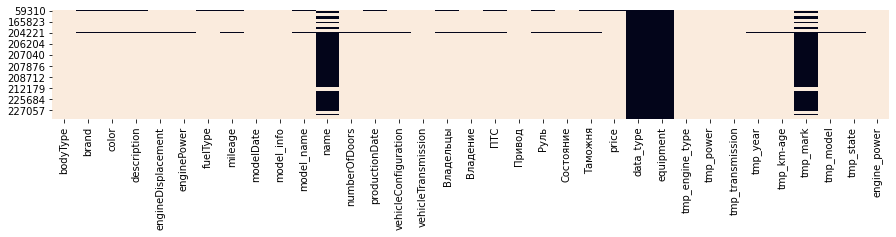

In [16]:
# оценим, а что там в целом с пропусками в датасете, где пропущен "engine_power"
fig, ax = plt.subplots(figsize=(15, 2))
fig.patch.set_facecolor("xkcd:white")
sns.heatmap(df[df.engine_power.isna()].isna(), cbar=False, ax=ax)
plt.show()

In [17]:
# судя по графику, информация по этим объявлениям отсутсвует полностью.
# нет смысла что-то с ними делать, поэтом просто дропнем их, исключив датасет "test"
df.drop(df[(df.engine_power.isna()) & (df.data_type != 0)].index, inplace=True)
# и удалим уже ненужные колонки: оригинальную "enginePower" и "tmp_power", полученную из "super_gen"
df.drop(["tmp_power", "enginePower"], axis=1, inplace=True)


## brand
Есть две колонки: "tmp_mark" и "brand". Форматируем "brand" и смотрим, есть ли пропуски. Если есть, пробуем заполнить из "tmp_mark", потом "tmp_brand" удаляем.

In [18]:
describe_column(df, "brand")

           data type: object
       unique values: 36
               total: 254049
           brand nan: 0.0% = 0        (0/0/0)


In [19]:
print(list(df.brand.unique()))

['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI', 'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HYUNDAI', 'JAGUAR', 'JEEP', 'KIA', 'MAZDA', 'MINI', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'SUBARU', 'SUZUKI', 'GREAT_WALL', 'LAND_ROVER', 'SSANG_YONG']


In [20]:
# видно, что с колонкой "brand" все хорошо, пропусков нет
# переведем в нижний регистр и удалим "tmp_mark"
df.brand = df.brand.str.lower()
df.drop(["tmp_mark"], axis=1, inplace=True)


## year
Есть две колонки: "productionDate" и "tmp_year" отвечающие за год производства. Форматируем "productionDate". Потом проопуски пытаемся заполнить из на основе "tmp_year". Сводим все в колонку "year", исходные данные дропаем.

In [21]:
describe_column(df, "productionDate")

           data type: float64
       unique values: 81
               total: 254049
  productionDate nan: 0.0% = 0        (0/0/0)


In [22]:
print(list(df.productionDate.unique()))

[2014.0, 2017.0, 2012.0, 2011.0, 2019.0, 2018.0, 2010.0, 2020.0, 2016.0, 2013.0, 2006.0, 2007.0, 2015.0, 2005.0, 2008.0, 2009.0, 1997.0, 2004.0, 2002.0, 1987.0, 2003.0, 2001.0, 1976.0, 2000.0, 1998.0, 1995.0, 1999.0, 1993.0, 1939.0, 1996.0, 1984.0, 1990.0, 1991.0, 1992.0, 1989.0, 1982.0, 1985.0, 1994.0, 1938.0, 1981.0, 1988.0, 1983.0, 1980.0, 1986.0, 1978.0, 1970.0, 1979.0, 1977.0, 1972.0, 1975.0, 1969.0, 1950.0, 1953.0, 1949.0, 1937.0, 1959.0, 1968.0, 1936.0, 1904.0, 1974.0, 1967.0, 1961.0, 1960.0, 1965.0, 1963.0, 1957.0, 1952.0, 1973.0, 1948.0, 1955.0, 1964.0, 1971.0, 1931.0, 1927.0, 1923.0, 1924.0, 1932.0, 1951.0, 1954.0, 1966.0, 2021.0]


In [23]:
# с годом выпуска машины все хорошо, переименум "productionDate" и удалим "tmp_year"
# преобразовывать в DT не будем, оставим просто числом
df.rename(columns={"productionDate": "year"}, inplace=True)
df.drop(["tmp_year"], axis=1, inplace=True)


## model
Есть две колонки: "model_name" и "tmp_model" отвечающие за модель. Как и выше, форматируем "model_name", пытаемся заполнить пропуски и удаляем ненужные колонки.

In [24]:
describe_column(df, "model_name")

           data type: object
       unique values: 1507
               total: 254049
      model_name nan: 10.6% = 26954        (0/0/26954)


In [25]:
# сначала приводим все к одному регистру, затем разбираемся с пробелами
df.model_name = df.model_name.str.lower()
df.tmp_model = df.tmp_model.str.lower()

In [26]:
# попробуем обработать скобки, пробелы, тире и пр, путем заменой на "_" или удаления символа
model_dict = {
    "\+": "_plus_",
    "'": "_",
    "\s+": "_",
    "-+": "_",
    "\(|\)": "",
    ":": "_",
}
for old_str, new_str in model_dict.items():
    df.loc[:, "model_name"] = df.loc[:, "model_name"].str.replace(old_str, new_str, regex=True)
    df.loc[:, "tmp_model"] = df.loc[:, "tmp_model"].str.replace(old_str, new_str, regex=True)


In [27]:
# # список моделей по брендам, визуально оценим ваиративность написания,
# # и далее для каждого бренда попробуем отформатировать названия моделей

# for brand in df.brand.unique():
#     model_count = str(df.groupby("brand")["model_name"].nunique()[brand])
#     pprint("-" * 10 + brand + "-" * 10 + " models count: " + model_count)
#     pprint(sorted(df.loc[(df.brand == brand) & ~(df.model_name.isna()), "model_name"].unique()))

# for brand in df.brand.unique():
#     model_count = str(df.groupby("brand")["tmp_model"].nunique()[brand])
#     pprint("-" * 10 + brand + "-" * 10 + " models count: " + model_count)
#     pprint(sorted(df.loc[(df.brand == brand) & ~(df.tmp_model.isna()), "tmp_model"].unique()))


In [28]:
# форматирование моделей для mercedes
model_dict = {
    "190_w201": "w201",
    "190_sl": "w121",
    "_класс": "",
    "_klasse": "",
    "_class": "",
    "s_maybach": "maybach_s",
    "^amg_(.*)$": "\\1_amg",
}

for old_str, new_str in model_dict.items():
    format_model_name(df, "mercedes", "model_name", old_str, new_str)
    format_model_name(df, "mercedes", "tmp_model", old_str, new_str)

In [29]:
# форматирование моделей для bmw
model_dict = {
    "_серии": "",
    "^02$": "2",
    "^3..$": "3",
    "([a-zA-Z]+)tourer": "_\\1_tourer",
    "grand_tourer": "gran_tourer",
    "_m$": "m",
    "(\d)+er$": "\\1",
}
for old_str, new_str in model_dict.items():
    format_model_name(df, "bmw", "model_name", old_str, new_str)
    format_model_name(df, "bmw", "tmp_model", old_str, new_str)


In [30]:
# форматирование моделей для toyota
model_dict = {"rav4": "rav_4"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "toyota", "model_name", old_str, new_str)
    format_model_name(df, "toyota", "tmp_model", old_str, new_str)

In [31]:
# форматирование моделей для nissan
model_dict = {"rnessa": "r_nessa"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "nissan", "model_name", old_str, new_str)
    format_model_name(df, "nissan", "tmp_model", old_str, new_str)

In [32]:
# форматирование моделей для honda
model_dict = {"odyssey_north_america": "odyssey_na"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "honda", "model_name", old_str, new_str)
    format_model_name(df, "honda", "tmp_model", old_str, new_str)

In [33]:
# форматирование моделей для mitsubishi
model_dict = {"delica_d2": "delica_d_2"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "mitsubishi", "model_name", old_str, new_str)
    format_model_name(df, "mitsubishi", "tmp_model", old_str, new_str)

In [34]:
# форматирование моделей для audi
model_dict = {"rs_(\d)": "rs\\1", "rs_q3": "rsq3"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "audi", "model_name", old_str, new_str)
    format_model_name(df, "audi", "tmp_model", old_str, new_str)

In [35]:
# форматирование моделей для skoda
model_dict = {"105,_120": "120", "100_series": "100"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "skoda", "model_name", old_str, new_str)
    format_model_name(df, "skoda", "tmp_model", old_str, new_str)

In [36]:
# форматирование моделей для volvo
model_dict = {"_series": "", "_cc": "_cross_country"}
for old_str, new_str in model_dict.items():
    format_model_name(df, "volvo", "model_name", old_str, new_str)
    format_model_name(df, "volvo", "tmp_model", old_str, new_str)

In [37]:
describe_column(df, "model_name")

           data type: object
       unique values: 1143
               total: 254049
      model_name nan: 10.6% = 26954        (0/0/26954)


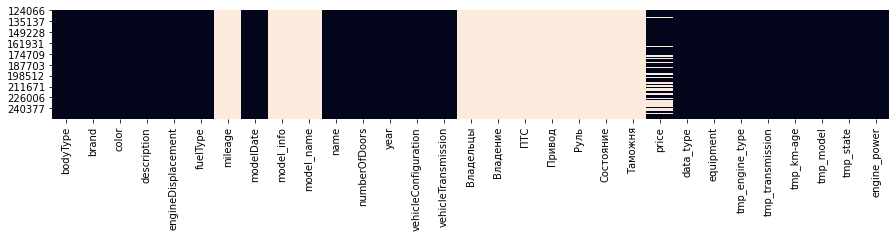

In [38]:
# моделей стало меньше, форматирование помогло.
# пропуски есть, попробуем оценить графически
fig, ax = plt.subplots(figsize=(15, 2))
fig.patch.set_facecolor("xkcd:white")
sns.heatmap(df[df.model_name.isna()].isna(), cbar=False, ax=ax)
plt.show()

In [39]:
# видно, что пропуски можно заполнить на основе "tmp_model"
df.model_name.fillna(df.tmp_model, inplace=True)
# удалим более не нужную колонку "tmp_model"
df.drop(["tmp_model"], axis=1, inplace=True)


In [40]:
# посмотрим, сколько пропусков осталось в "model_name"
df[df.model_name.isna()].shape[0]

29

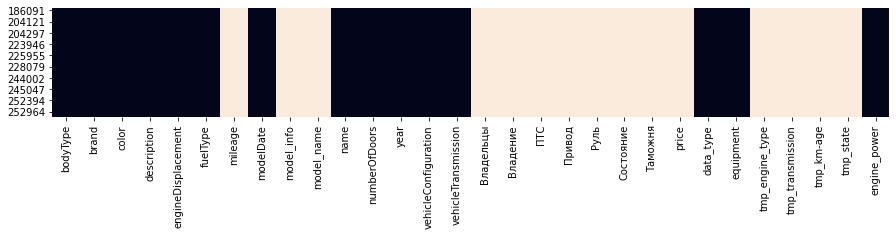

In [41]:
# в графическом виде
fig, ax = plt.subplots(figsize=(15, 2))
fig.patch.set_facecolor("xkcd:white")
sns.heatmap(df[df.model_name.isna()].isna(), cbar=False, ax=ax)
plt.show()

In [42]:
# видно, что записей с пропусками всего 29. и у них у всех отсутсвует "price", т.е. для нас эти записи бесполезны,
# проверим, что среди этих записей нет тестового датасета
df[df.model_name.isna()].data_type.value_counts()

2    29
Name: data_type, dtype: int64

In [43]:
# и удалим пропуски
df.drop(df[(df.model_name.isna()) & (df.data_type != 0)].index, inplace=True)

## body_type (bodyType)
Тип кузова, пропусков нет. Форматируем следующим образом: все в lowercase и берем только первое слово, так как оно отвечает за тип.

In [44]:
# сменим название на snake_case
df.rename(columns={"bodyType": "body_type"}, inplace=True)
describe_column(df, "body_type")

           data type: object
       unique values: 192
               total: 254020
       body_type nan: 0.0% = 0        (0/0/0)


In [45]:
# # Посмотрим список всех типов кузова
# pprint(sorted(list(df.body_type.unique())))

In [46]:
# регистр
df.body_type = df.body_type.str.lower()
# берем первое слово
df.body_type = df.body_type.apply(lambda x: x.split()[0].strip())
df.body_type = df.body_type.apply(lambda x: x.split("-")[0].strip())

In [47]:
# пропусков нет
describe_column(df, "body_type")

           data type: object
       unique values: 16
               total: 254020
       body_type nan: 0.0% = 0        (0/0/0)


## color
цвет есть текстом и хексом. Пропусков нет, приводим все к одному виду.

In [48]:
describe_column(df, "color")

           data type: object
       unique values: 32
               total: 254020
           color nan: 0.0% = 0        (0/0/0)


In [49]:
# пропусков нет, возможные значения
print(list(df.color.unique()))

['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный', 'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый', 'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый', '040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB', '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522', '4A2197', 'FFD600', 'FF8649', 'FFC0CB']


In [50]:
# словарь для замены цвета на текст, ограничимся только нашими данными
color_dict = {
    "040001": "чёрный",
    "EE1D19": "красный",
    "0000CC": "синий",
    "CACECB": "серебристый",
    "007F00": "зелёный",
    "FAFBFB": "белый",
    "97948F": "серый",
    "22A0F8": "голубой",
    "660099": "пурпурный",
    "200204": "коричневый",
    "C49648": "бежевый",
    "DEA522": "золотистый",
    "4A2197": "фиолетовый",
    "FFD600": "жёлтый",
    "FF8649": "оранжевый",
    "FFC0CB": "розовый",
}
df.color.replace(to_replace=color_dict, inplace=True)


In [51]:
describe_column(df, "color")

           data type: object
       unique values: 16
               total: 254020
           color nan: 0.0% = 0        (0/0/0)


## fuel_type
тип топлива (двигателя)

In [52]:
df.rename(columns={"fuelType": "engine_type"}, inplace=True)
describe_column(df, "engine_type")

           data type: object
       unique values: 5
               total: 254020
     engine_type nan: 0.0% = 0        (0/0/0)


бензин     204034
дизель      47801
гибрид       1584
электро       581
газ            20
Name: engine_type, dtype: int64

In [53]:
# пропусков нет, заменим rus->eng
engine_type_dict = {
    "бензин": "gasoline",
    "дизель": "diesel",
    "гибрид": "hybrid",
    "электро": "electro",
    "газ": "lpg",
}

df.engine_type = df.engine_type.apply(map_rus_to_eng, args=(engine_type_dict,))

In [54]:
# удалим ненужную колонку
df.drop(["tmp_engine_type"], axis=1, inplace=True)


## engine_displacement
объем двигателя. парсим объем во float. пропуски в конце попробуем заполнить на основе модели и мощности двигателя.

In [55]:
df.rename(columns={"engineDisplacement": "engine_displacement"}, inplace=True)
describe_column(df, "engine_displacement")

           data type: object
       unique values: 589
               total: 254020
engine_displacement nan: 0.0% = 0        (0/0/0)


In [56]:
# форматируем данные
df.engine_displacement = df.engine_displacement.apply(format_engine_displacement)

In [57]:
# посмотрим, сколько пропусков осталось в каждом из типов датасетов
# видим, что подавляющее большенство получилось от train_basic.
df[df.engine_displacement.isna()].data_type.value_counts()

1    21068
2      415
0       55
Name: data_type, dtype: int64

In [58]:
# если посмотреть исходный датасет ("train_dasic"=1), то видно, что в нем изначально
# вместо объема двигателя была модель и объем может быть получен из колонки "name"
train_basic.loc[6231, ["name", "engineDisplacement"]]


name                  520i 2.0 AT (184 л.с.)
engineDisplacement                      520i
Name: 6231, dtype: object

In [59]:
# заполним пропуски колонкой "name" и снова отформатируем значениия
df.engine_displacement.fillna(df.name, inplace=True)
df.engine_displacement = df.engine_displacement.apply(format_engine_displacement)

In [60]:
df[df.engine_displacement.isna()].data_type.value_counts()

2    413
1    109
0     55
Name: data_type, dtype: int64

In [61]:
# стало лучше. но все равно есть пропуски
# теперь посмотрим, что за тип двигатели у записей с пропусками
df[df.engine_displacement.isna()].engine_type.unique()

array(['electro'], dtype=object)

In [62]:
# только электрокары, для них этот параметр не актуален, поэтом просто заполним пропуски нулями
df.engine_displacement.fillna(0, inplace=True)

## mileage
пробег

In [63]:
# посмотрим характеристики стобца
describe_column(df, "mileage")

           data type: float64
       unique values: 36560
               total: 254020
         mileage nan: 10.6% = 26925        (0/0/26925)


In [64]:
# пропусков достаточно много, но все они из "train_extra", ранее мы парсили "super_gen" и там была опция "state"
# посмотрим, какие статусы у авто с пропусками пробега
df[df.mileage.isna()].tmp_state.unique()

array(['new'], dtype=object)

In [65]:
# получается все пропуски это новые авто, заполним все пропуски пробега нулями
# вероятно test и train_basic собирались только по подержанным авто, а train_extra по новым и подерджанным
# возможно стоит в будущем сравнить результаты с и без новых авто
# преобразовывать в DT не будем, оставим просто числом
df.mileage.fillna(0, inplace=True)

In [66]:
df.drop(["tmp_km-age"], axis=1, inplace=True)

## model_date (modelDate)
Модельный год. У нас есть год выпуска авто, это более важнный фактор для цены. Скорее всего просто удалим этот столбец, но в конце, когда посмотрим на общую картину, построим матрцу корреляции и проведем feature engineering

In [67]:
df.rename(columns={"modelDate": "model_date"}, inplace=True)
describe_column(df, "model_date")

           data type: float64
       unique values: 80
               total: 254020
      model_date nan: 0.0% = 0        (0/0/0)


In [68]:
# пропусков нет
# приверим, есть ли машины у которых год выпуска старше, чем модельный год, и на сколько расхождение
(df[df.model_date > df.year].model_date - df[df.model_date > df.year].year).value_counts()

1.0    16
2.0     7
3.0     2
dtype: int64

In [69]:
# в основном это ошибка на 1 год, поэтому заменним для этих машин год выпуска на модельный
df.loc[df.year - df.model_date < 0, "year"] = df.loc[df.year - df.model_date < 0, "model_date"]


## model_info
дропаем колонку, модель/производитель у нас уже заполнены, больше в "model_info" интересной информации нет

In [70]:
df.drop(["model_info"], axis=1, inplace=True)

## name
аналогично, модель/производитель/двигатель у нас уже заполнены, больше в "name" интересной информации нет

In [71]:
df.drop(["name"], axis=1, inplace=True)

## number_of_doors (numberOfDoors)
число дверей

In [72]:
df.rename(columns={"numberOfDoors": "number_of_doors"}, inplace=True)
describe_column(df, "number_of_doors")

           data type: float64
       unique values: 5
               total: 254020
 number_of_doors nan: 0.0% = 0        (0/0/0)


5.0    160993
4.0     82898
2.0      6023
3.0      4104
0.0         2
Name: number_of_doors, dtype: int64

In [73]:
# машины без дверей
df[df.number_of_doors == 0]


,body_type,brand,color,description,engine_displacement,engine_type,mileage,model_date,model_name,number_of_doors,...,Привод,Руль,Состояние,Таможня,price,data_type,equipment,tmp_transmission,tmp_state,engine_power
16944,кабриолет,mercedes,белый,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,gasoline,48000.0,1904.0,simplex,0.0,...,задний,Правый,Не требует ремонта,Растаможен,0.0,0,{},mechanical,NaN,32.0
122751,кабриолет,mercedes,белый,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,gasoline,48000.0,1904.0,simplex,0.0,...,задний,RIGHT,NaN,True,12000000.0,1,{},NaN,NaN,32.0


In [74]:
# оба кабриолеты, там, как минимум 2 двери есть, правим это
df.loc[df.number_of_doors == 0, "number_of_doors"] = 2


## vehicleConfiguration
описание авто: модель/объем двигателя/трансмиссия. у нас уже это все есть, удаляем

In [75]:
df.drop(["vehicleConfiguration"], axis=1, inplace=True)

## transmission
тип трансмиссии

In [76]:
df.rename(columns={"vehicleTransmission": "transmission"}, inplace=True)
describe_column(df, "transmission")

           data type: object
       unique values: 8
               total: 254020
    transmission nan: 0.0% = 0        (0/0/0)


автоматическая      93424
AUTOMATIC           49218
вариатор            28446
MECHANICAL          25264
механическая        22694
роботизированная    20079
ROBOT                7871
VARIATOR             7024
Name: transmission, dtype: int64

In [77]:
# меняем регистр и переводим все в английские имена
df.transmission = df.transmission.str.lower()

transmission_dict = {
    "механическая": "mechanical",
    "автоматическая": "automatic",
    "вариатор": "variator",
    "роботизированная": "robot",
}

df.transmission = df.transmission.apply(map_rus_to_eng, args=(transmission_dict,))

In [78]:
# финальная проверка
describe_column(df, "transmission")

           data type: object
       unique values: 4
               total: 254020
    transmission nan: 0.0% = 0        (0/0/0)


automatic     142642
mechanical     47958
variator       35470
robot          27950
Name: transmission, dtype: int64

In [79]:
# удаляем ненужную информацию
df.drop(["tmp_transmission"], axis=1, inplace=True)

## state_new (tmp_state)
состояние (новый/подержанная). Эта информация так же опеределяется из пробега, но обработаем столбец и пока оставим. 

In [80]:
df.rename(columns={"tmp_state": "state_new"}, inplace=True)
describe_column(df, "state_new")

           data type: object
       unique values: 3
               total: 254020
       state_new nan: 48.9% = 124124        (34686/89377/61)


used    102971
new      26925
Name: state_new, dtype: int64

In [81]:
# пропусков много, но варианта всего два: новая/подержанная, заполним пропуски на основе пробега
df.loc[df.state_new.isna(), "state_new"] = np.where(df.loc[df.state_new.isna(), "mileage"] == 0, "new", "used")

In [82]:
df.state_new = df.state_new.apply(lambda value: 1 if value == "new" else 0)


In [83]:
describe_column(df, "state_new")

           data type: int64
       unique values: 2
               total: 254020
       state_new nan: 0.0% = 0        (0/0/0)


0    213507
1     40513
Name: state_new, dtype: int64

## owners
число владельцев. помним, что у нас есть новые машины, поэтомы возможные пропуски в первую очередь проверим на состояние машины (новая или нет) и заполним нулями для новых авто. все остальное пропуски заполним единицами.

In [84]:
df.rename(columns={"Владельцы": "owners"}, inplace=True)
describe_column(df, "owners")

           data type: object
       unique values: 9
               total: 254020
          owners nan: 15.9% = 40513        (0/13588/26925)


3 или более    49759
1 владелец     40575
3.0            36247
2 владельца    28655
2.0            21006
1.0            18536
1 владелец      9459
2 владельца     9270
Name: owners, dtype: int64

In [85]:
df[df.owners.isna()].state_new.value_counts()

1    40513
Name: state_new, dtype: int64

In [86]:
# все пропуски это новые авто, заполним нулями
df.loc[(df.owners.isna()) & (df.state_new == 1), "owners"] = 0


In [87]:
# пропуски зааполнили, теперь вариацию владельцев приведем к чилу, взяв первое число в строке
df.owners = df.owners.apply(lambda x: float(str(x).split()[0]))

## ownership
с какого года авто у последнего владельца

In [88]:
describe_column(df, "Владение")

           data type: object
       unique values: 596
               total: 254020
        Владение nan: 78.2% = 198539        (22691/60176/115672)


In [89]:
# пропусков очень много, да и непонятно, что эта колонка может дать. удалим её
df.drop(["Владение"], axis=1, inplace=True)

## vehicle_licence_original (ПТС)
информация о ПТС, оригинал/дубликат

In [90]:
df.rename(columns={"ПТС": "vehicle_licence_original"}, inplace=True)
describe_column(df, "vehicle_licence_original")

           data type: object
       unique values: 5
               total: 254020
vehicle_licence_original nan: 10.7% = 27287        (1/361/26925)


Оригинал     122683
ORIGINAL      78596
Дубликат      15034
DUPLICATE     10420
Name: vehicle_licence_original, dtype: int64

In [91]:
# нужно сменить регистр и заменить rus->eng, и поменять на 0/1. но сначала посмотрим на пропуски,
# а конкретнее на состояние (или пробег) у машин с пропусками
df[df.vehicle_licence_original.isna()].state_new.value_counts()

1    27286
0        1
Name: state_new, dtype: int64

In [92]:
# получается все, кроме одного, пропуски это новые авто. думаю для них можно поставить ПТС равным "original"
df.loc[(df.vehicle_licence_original.isna()) & (df.mileage == 0), "vehicle_licence_original"] = "original"


In [93]:
# посмотрим на оставшееся одно авто
df[df.vehicle_licence_original.isna()]

,body_type,brand,color,description,engine_displacement,engine_type,mileage,model_date,model_name,number_of_doors,...,vehicle_licence_original,Привод,Руль,Состояние,Таможня,price,data_type,equipment,state_new,engine_power
10412,седан,bmw,синий,"Сделано большое Т.О. Фильтра масляный, воздушн...",2.5,gasoline,276000.0,1998.0,3,4.0,...,NaN,задний,Левый,Не требует ремонта,Растаможен,0.0,0,{},0,170.0


In [94]:
# bmw 1999 года, с 3 или более владельцами. ставим ПТС как дубликат
df.loc[df.vehicle_licence_original.isna(), "vehicle_licence_original"] = "duplicate"

In [95]:
# меняем регистр и язык
vehicle_licence_dict = {
    "оригинал": "original",
    "дубликат": "duplicate",
}

df.vehicle_licence_original = df.vehicle_licence_original.str.lower()
df.vehicle_licence_original = df.vehicle_licence_original.apply(map_rus_to_eng, args=(vehicle_licence_dict,))
df.vehicle_licence_original = df.vehicle_licence_original.apply(lambda value: 1 if value == "original" else 0)


## drivetrain (привод)
колонка с типом привода авто

In [96]:
df.rename(columns={"Привод": "drivetrain"}, inplace=True)
describe_column(df, "drivetrain")

           data type: object
       unique values: 4
               total: 254020
      drivetrain nan: 10.6% = 26925        (0/0/26925)


полный      108584
передний    100745
задний       17766
Name: drivetrain, dtype: int64

In [97]:
# пропусков достаточно много. заполнять будем так: для каждой пары производитель-модель
# найдем самый популярный вариант привода и на основе этого заполним пропуски для конкретных моделей
# на всякий случай (если в пропуске есть какие-то уникальные авто), передадим в функцию
# "дефолтное значение" - самый популярный привод во всем датасете
groupped_series = df.groupby(["brand", "model_name"]).drivetrain.value_counts()
default_value = df.drivetrain.value_counts().index[0]
df.loc[df.drivetrain.isna(), "drivetrain"] = df[df.drivetrain.isna()].apply(
    lambda row: fill_from_groupped_series(groupped_series, row.brand, row.model_name, default_value),
    axis=1,
)

In [98]:
# проверим результат - все ок
describe_column(df, "drivetrain")

           data type: object
       unique values: 3
               total: 254020
      drivetrain nan: 0.0% = 0        (0/0/0)


полный      130019
передний    105288
задний       18713
Name: drivetrain, dtype: int64

In [99]:
# меняем регистр и язык
drivetrain_dict = {
    "полный": "4wd",
    "передний": "fwd",
    "задний": "rwd",
}

df.drivetrain = df.drivetrain.str.lower()
df.drivetrain = df.drivetrain.apply(map_rus_to_eng, args=(drivetrain_dict,))

## steering_wheel_left (Руль)
левый/правый руль. 

In [100]:
df.rename(columns={"Руль": "steering_wheel_left"}, inplace=True)
describe_column(df, "steering_wheel_left")

           data type: object
       unique values: 5
               total: 254020
steering_wheel_left nan: 10.6% = 26926        (0/0/26926)


Левый     132641
LEFT       87588
Правый      5076
RIGHT       1789
Name: steering_wheel_left, dtype: int64

In [101]:
# сначала приведем существующие значения к одному виду
steering_wheel_dict = {
    "левый": "left",
    "правый": "right",
}

df.steering_wheel_left = df.steering_wheel_left.str.lower()
df.steering_wheel_left = df.steering_wheel_left.apply(map_rus_to_eng, args=(steering_wheel_dict,))

In [102]:
# подавляющее большенство это леворульные машины, но заполним аналогочно тому, как заполняли привод
groupped_series = df.groupby(["brand", "model_name"]).steering_wheel_left.value_counts()
default_value = df.steering_wheel_left.value_counts().index[0]
df.loc[df.steering_wheel_left.isna(), "steering_wheel_left"] = df[df.steering_wheel_left.isna()].apply(
    lambda row: fill_from_groupped_series(groupped_series, row.brand, row.model_name, default_value),
    axis=1,
)

In [103]:
df.steering_wheel_left = df.steering_wheel_left.apply(lambda value: 1 if value == "left" else 0)


## condition_good (Состояние)
колонка с информацией о состоянии авто (нужен ремонт или нет)
- 1 - хорошее (не требует ремонта)
- 0 - плохое

In [104]:
df.rename(columns={"Состояние": "condition_good"}, inplace=True)
describe_column(df, "condition_good")

           data type: object
       unique values: 2
               total: 254020
  condition_good nan: 45.8% = 116304        (0/89377/26927)


Не требует ремонта    137716
Name: condition_good, dtype: int64

In [105]:
# значения заполнены только на половину, и единственный вариант в данных это "не требует ремента"
# заменим это на 1 + новым машинам так же 1 поставим, все остальное сделаем 0,
# не факт, что все машины с condition_good=0 требуют ремонта, но мы об этом не знаем
df.condition_good = df.condition_good.str.replace("Не требует ремонта", "1")
df.loc[(df.condition_good.isna()) & (df.state_new == 1), "condition_good"] = "1"
df.condition_good.fillna("0", inplace=True)
df.condition_good = df.condition_good.astype("int64")

In [106]:
describe_column(df, "condition_good")

           data type: int64
       unique values: 2
               total: 254020
  condition_good nan: 0.0% = 0        (0/0/0)


1    178229
0     75791
Name: condition_good, dtype: int64

In [107]:
# переведем в числовой формат
df.condition_good = df.condition_good.apply(int).astype("int64")

## customs (Таможня)
растаможен или нет

In [108]:
df.rename(columns={"Таможня": "customs"}, inplace=True)
describe_column(df, "customs")

           data type: object
       unique values: 3
               total: 254020
         customs nan: 10.6% = 26929        (0/0/26929)


Растаможен    137714
True           89377
Name: customs, dtype: int64

In [109]:
# вариантов "не растаможен" нет, думаю колонка бесполезна в существующем виде, удалим её
df.drop(["customs"], axis=1, inplace=True)

## price
это наш целевой параметр, делаем следующее: все пропуски удаляем (в "test" пропусков быть не должно, т.к. мы сами добавляли эту колонку с нулевыми значениями). Для "train_extra" нужна корректировка по цене, т.к. данные собирались во второй половине 2021 года, а тестовый датасет за 2020 год. Исходя из данных автостата, подорожание год к году (2021-2020) было около 10-15%, но это "средняя температура по больнице", так как она не учитывает, что разные сегменты (премиум/эконом/и тд) дорожали по-разному, а так же такие факторы, как выпуск рестайлингов или смену поколения модели. Но у нас другого выхода нет, поэтому уменьшим price в train_extra на корректировочной коэффициент, если нужно будет, можно попробовать его поменять в будущем, что бы подобрать лучшее значение метрики.

In [110]:
describe_column(df, "price")

           data type: float64
       unique values: 13377
               total: 254020
           price nan: 8.1% = 20603        (0/410/20193)


In [111]:
# видим, что все пропуски из обучающих датасетов, поэтому просто удаляем их, взять информацию о цене нам неоткуда
df.dropna(subset=["price"], inplace=True)

In [112]:
# корректируем цены в train_extra
df.loc[df.data_type == 2, "price"] = round(df.loc[df.data_type == 2, "price"] * PRICE_CORRECTION)


# Feature engineering
добавим следующие колонки на основе имещихся данных
- binary колонки
    - warranty - старше машина трех лет или нет. обычно три года это срок гарантии, возможно цена будет зависеть от того, на гарантии авто (1) или нет (0). При этом для test и train_basic отсчет идет от 2020, а для train_extra с 2021
    - popular_body - наиболее популярный тип кузова это внедорожник и седан, сделаем на основе этого колонку, популярный тип кузова получает значение равное 1
    - rarity_car - раритетные авто или нет, авто старше 1950 года получают 1 в колонке
    - old_car - старые авто, записи старше 2000 г.в. получают 1 в колонке. тут (как и в rarity_car) год мной выбирался субъективно, 20 лет, с моей т.з., уже достаточно, что бы считать машину старой
    - new_car - если машина моложе 5 лет, получает 1 в колонке
    - color_top5 - топ 5 используемых цветов (определим их после), получают 1 в колонке
    - color_rare - топ 5 с конца используемых цветов получают 1
- numerical колонки
    - description_count - число слов в описании
    - model_age - насколько стара машина относительно даты выпуска модели
    - mil_per_year - пробег в год
    


In [113]:
# заполняем колонку "warranty"
df["warranty"] = np.nan
df.loc[df.data_type == 2, "warranty"] = (2018 < df.loc[df.data_type == 2, "year"]).apply(int)
df.loc[df.data_type != 2, "warranty"] = (2017 < df.loc[df.data_type != 2, "year"]).apply(int)
describe_column(df, "warranty")

           data type: float64
       unique values: 2
               total: 233417
        warranty nan: 0.0% = 0        (0/0/0)


0.0    177946
1.0     55471
Name: warranty, dtype: int64

In [114]:
# заполняем колонку "popular_body"
df["popular_body"] = np.nan
popular_body = list(df.body_type.value_counts().index)[:2]
df.popular_body = df.body_type.apply(lambda body_type: 1 if body_type in popular_body else 0)
describe_column(df, "popular_body")

           data type: int64
       unique values: 2
               total: 233417
    popular_body nan: 0.0% = 0        (0/0/0)


1    178368
0     55049
Name: popular_body, dtype: int64

In [115]:
# заполняем колонку "rarity_car"
df["rarity_car"] = np.nan
df.loc[:, "rarity_car"] = (1950 > df.loc[:, "year"]).apply(int)
describe_column(df, "rarity_car")

           data type: int64
       unique values: 2
               total: 233417
      rarity_car nan: 0.0% = 0        (0/0/0)


0    233386
1        31
Name: rarity_car, dtype: int64

In [116]:
# заполняем колонку "old_car"
df["old_car"] = np.nan
df.loc[:, "old_car"] = (2000 > df.loc[:, "year"]).apply(int)
describe_column(df, "old_car")

           data type: int64
       unique values: 2
               total: 233417
         old_car nan: 0.0% = 0        (0/0/0)


0    221328
1     12089
Name: old_car, dtype: int64

In [117]:
# заполняем колонку "new_car"
df["new_car"] = np.nan
df.loc[df.data_type == 2, "new_car"] = (2016 < df.loc[df.data_type == 2, "year"]).apply(int)
df.loc[df.data_type != 2, "new_car"] = (2015 < df.loc[df.data_type != 2, "year"]).apply(int)
describe_column(df, "new_car")

           data type: float64
       unique values: 2
               total: 233417
         new_car nan: 0.0% = 0        (0/0/0)


0.0    150005
1.0     83412
Name: new_car, dtype: int64

In [118]:
# заполняем колонку "color_top5"
df["color_top5"] = np.nan
color_top5 = list(df.color.value_counts().index)[:5]
df.color_top5 = df.color.apply(lambda color: 1 if color in color_top5 else 0)
describe_column(df, "color_top5")

           data type: int64
       unique values: 2
               total: 233417
      color_top5 nan: 0.0% = 0        (0/0/0)


1    194415
0     39002
Name: color_top5, dtype: int64

In [119]:
# заполняем колонку "color_rare"
df["color_rare"] = np.nan
color_rare = list(df.color.value_counts().index)[-5:]
df.color_rare = df.color.apply(lambda color: 1 if color in color_rare else 0)
describe_column(df, "color_rare")

           data type: int64
       unique values: 2
               total: 233417
      color_rare nan: 0.0% = 0        (0/0/0)


0    229014
1      4403
Name: color_rare, dtype: int64

In [120]:
# заполняем колонку "description_count" и удаляем "description"
df["description_count"] = np.nan
df.description_count = df.description.apply(
    lambda text: len(re.findall(r"\w{3,}", text)) if isinstance(text, str) else 0
)
df.drop(["description"], axis=1, inplace=True)
describe_column(df, "description_count")

           data type: int64
       unique values: 1144
               total: 233417
description_count nan: 0.0% = 0        (0/0/0)


In [121]:
# заполняем колонку "mil_per_year"
# возраст расчитываем как 2022 - год.выпуска (для train_extra). Т.о. не будет деления на 0 и учтутся ситууации
# когда машина в 2021 году была сделана/куплена, продается и уже успела проехать сколько-то км.
df["mil_per_year"] = np.nan
df.loc[df.data_type == 2, "mil_per_year"] = round(
    df.loc[df.data_type == 2, "mileage"] / (2022 - df.loc[df.data_type == 2, "year"])
)
df.loc[df.data_type != 2, "mil_per_year"] = round(
    df.loc[df.data_type != 2, "mileage"] / (2021 - df.loc[df.data_type != 2, "year"])
)
describe_column(df, "mil_per_year")

           data type: float64
       unique values: 21572
               total: 233417
    mil_per_year nan: 0.0% = 0        (0/0/0)


# Анализ

In [122]:
# # сделаем отчет отчет по исходным данным
# profile = pandas_profiling.ProfileReport(
#     df.loc[:, df.columns != "equipment"],
#     title="Profiling Report",
# )
# profile.to_file("car_price_prediction.html")

## engine_displacement

In [123]:
# Из профайлинга можно сказать, что есть необычные значения в объеме двигетеля (engine_displacement). посмотрим их
df[df.engine_displacement > 10]

,body_type,brand,color,engine_displacement,engine_type,mileage,model_date,model_name,number_of_doors,year,...,engine_power,warranty,popular_body,rarity_car,old_car,new_car,color_top5,color_rare,description_count,mil_per_year
118306,внедорожник,mercedes,чёрный,300.0,electro,1771.0,2019.0,eqc,5.0,2020.0,...,408.0,1.0,1,0,0,1.0,1,0,526,1771.0
118307,внедорожник,mercedes,чёрный,300.0,electro,90.0,2019.0,eqc,5.0,2020.0,...,408.0,1.0,1,0,0,1.0,1,0,377,90.0
244013,фургон,mitsubishi,серебристый,16.0,electro,10761.0,1999.0,minicab,5.0,2012.0,...,41.0,0.0,0,0,0,0.0,1,0,119,1076.0
245505,фургон,mitsubishi,серебристый,16.0,electro,10761.0,1999.0,minicab,5.0,2012.0,...,41.0,0.0,0,0,0,0.0,1,0,119,1076.0


In [124]:
# электрокары, для них объем должны быть равен 0, поэтому проверим значения для всех электро, и заменим их на 0
df.loc[df.engine_type == "electro", "engine_displacement"].value_counts()

0.0      261
16.0       2
300.0      2
Name: engine_displacement, dtype: int64

In [125]:
# не нулевые только 4 записи, поэтому пройдем по электрокарам еще разз
df.loc[df.engine_type == "electro", "engine_displacement"] = 0


## description_count

max: 3506
min: 0
med: 74.0
25 percentile: 28.0
75 percentile: 157.0
Outlier left: -165.5
Outlier left count: 0
Outlier right: 350.5
Outlier right count: 23669


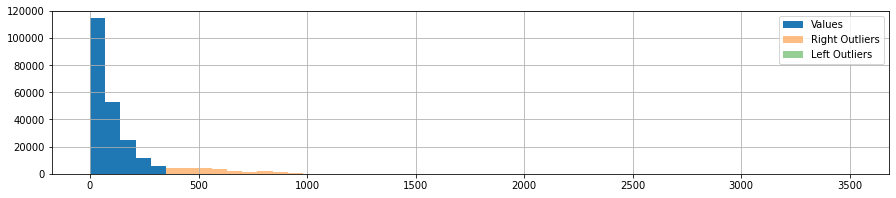

In [126]:
# из профайлинга так видно, что есть явные выбросы в description_count, посмотрим более детально
show_histogram(df, "description_count", df.description_count.max(), bins=50)


max: 3506
min: 351
med: 555.0
25 percentile: 444.0
75 percentile: 658.0
Outlier left: 123.0
Outlier left count: 0
Outlier right: 979.0
Outlier right count: 376


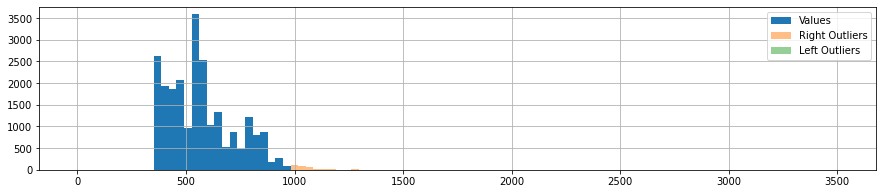

In [127]:
# посмотрим более детально на правый хвост выбросов
show_histogram(df.loc[df.description_count > 350, :], "description_count", df.description_count.max(), bins=100)

In [128]:
# обнулим все значения, большие 600
df.loc[df.description_count > 600, "description_count"] = 0

max: 6.398594934535208
min: 0.0
med: 4.204692619390966
25 percentile: 3.2188758248682006
75 percentile: 4.948759890378168
Outlier left: 0.6240497266032485
Outlier left count: 11210
Outlier right: 7.5435859886431205
Outlier right count: 0


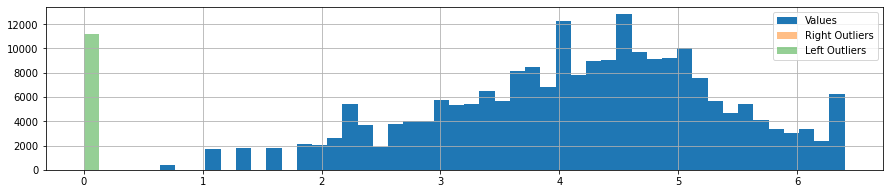

In [129]:
# распределение вцелом смещено влево, посмотрим на логирифмический вид
df["description_count_log"] = np.log(df.description_count + 1)
show_histogram(df, "description_count_log", df.description_count_log.max(), bins=50)

## price

max: 99000000.0
min: 16000.0
med: 1100000.0
25 percentile: 533600.0
75 percentile: 2244195.0
Outlier left: -2032292.5
Outlier left count: 0
Outlier right: 4810087.5
Outlier right count: 13583


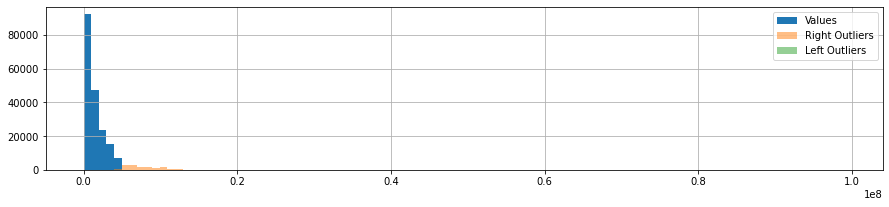

In [130]:
# сильно смещено влево
show_histogram(df.loc[df.data_type != 0, :], "price", df.price.max())

max: 18.410630418199872
min: 9.680406499268875
med: 13.910821646859095
25 percentile: 13.187403647644764
75 percentile: 14.623857885838977
Outlier left: 11.032722290353446
Outlier left count: 1036
Outlier right: 16.778539243130297
Outlier right count: 68


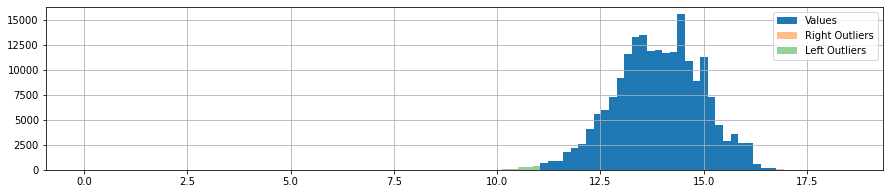

In [131]:
# логарифм выглядит лучше, попробуем его использовать при обучении
price_log = np.log(df.loc[df.data_type != 0, "price"] + 1).to_frame()
show_histogram(price_log, "price", price_log.price.max())

## Типы колонок

In [132]:
# Распределим колонки по типам
columns_cat = [
    "body_type",
    "brand",
    "color",
    "engine_type",
    "model_name",
    "transmission",
    "drivetrain",
    "owners",
    "number_of_doors",
]
columns_num = [
    "engine_displacement",
    "engine_power",
    "description_count",
    "description_count_log",
    "mileage",
    "mil_per_year",
    "year",
    "model_date",
]
columns_bin = [
    "vehicle_licence_original",
    "steering_wheel_left",
    "condition_good",
    "state_new",
    "warranty",
    "popular_body",
    "rarity_car",
    "old_car",
    "new_car",
    "color_top5",
    "color_rare",
]
columns_help = ["data_type"]
columns_set = ["equipment"]
columns_target = ["price"]

## Матрица корреляции числовых параметров

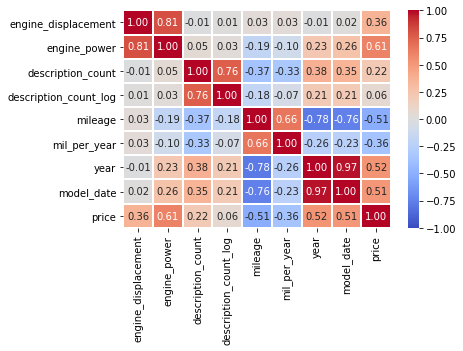

<Figure size 432x288 with 0 Axes>

In [133]:
# посмотрим корреляцию
fig, ax = plt.subplots()
fig.patch.set_facecolor("xkcd:white")
plt.figure(figsize=(6, 4))
sns.heatmap(
    df.loc[df.data_type != 0, columns_num + ["price"]].corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    linewidths=0.1,
    cmap="coolwarm",
    ax=ax,
)
plt.show()


In [134]:
# есть корреляция между мощностью двигателя и его объемом, общим пробегом и пробегом в год, количеством слов в описании и
# log2 вариантом этого параметра, годом выпуска и пробегом - все связи логичны, но связь, на мой взгляд, недостаточно сильная,
# оставим эти столбцы. между годом выпуска и годом модели сильная корреляция, причем год выпуска иимеет бОльшую связь с ценой.
# удалим модельный год

df.drop(["model_date"], axis=1, inplace=True)
columns_num.remove("model_date")

In [135]:
# description_count_log так же удалим
df.drop(["description_count_log"], axis=1, inplace=True)
columns_num.remove("description_count_log")


## Бинарные параметры
бинарные колонки приведены в профайлинге, дублировать тут смысла нет, никаких изменений делать не будем в них

# ML

In [136]:
# equipment содержит set с опциями, разобьем их по колонкам и выделим в отдельный датасет,
# проверим потом, есть какое-то влияние на МАРЕ или нет
mlb = MultiLabelBinarizer()
df_equipment = pd.DataFrame(mlb.fit_transform(df.equipment), columns=mlb.classes_, index=df.index)
# df = pd.concat([df, df_equipment], axis=1)
df.drop(["equipment"], axis=1, inplace=True)

In [137]:
# сохраним оба датасета в файле
df.to_csv("./df.csv", index=False)
df_equipment.to_csv("./df_equipment.csv", index=False)

In [138]:
# забегая вперед, попробовал catboost и понял, что там нужны колонки определенных типов данных,
# и некоторые вещи в обработке я делал зря. Переделывать не буду, так для остальных моделей это подходит,
# а вот для catboost сделаю отдельный датасет и зааменю тип колонок

df_catboost = df.copy()

columns_to_int = [
    "mileage",
    "mil_per_year",
    "engine_power",
    "price",
]
columns_to_str = [
    "engine_displacement",
    "number_of_doors",
    "year",
    "owners",
]
columns_to_yes_no = [
    "vehicle_licence_original",
    "steering_wheel_left",
    "warranty",
    "popular_body",
    "rarity_car",
    "old_car",
    "new_car",
    "color_top5",
    "color_rare",
    "condition_good",
    "state_new",
]

for column in columns_to_int:
    df_catboost[column] = df_catboost[column].apply(int)

for column in columns_to_str:
    df_catboost[column] = df_catboost[column].apply(str)

for column in columns_to_yes_no:
    df_catboost[column] = df_catboost[column].apply(lambda value: "yes" if value == 1 else "no")

body_type_dict = {
    "внедорожник": "cuv",
    "седан": "sedan",
    "хэтчбек": "hatchback",
    "лифтбек": "liftback",
    "минивэн": "minivan",
    "универсал": "wagon",
    "купе": "coupe",
    "компактвэн": "compact_mpv",
    "пикап": "pickup",
    "фургон": "trailer",
    "кабриолет": "convertible",
    "родстер": "roadster",
    "микровэн": "microvan",
    "лимузин": "limousine",
    "тарга": "targa",
    "фастбек": "fastback",
}

df_catboost.body_type = df_catboost.body_type.apply(map_rus_to_eng, args=(body_type_dict,))

# сохраним его так же в файл
df_catboost.to_csv("./df_catboost.csv", index=False)

In [139]:
# работаем с оригинальным датасетом
df[columns_num].describe()

,engine_displacement,engine_power,description_count,mileage,mil_per_year,year
count,233417.000000,233417.000000,233417.000000,233417.000000,233417.00000,233417.000000
mean,2.354892,191.140632,108.530069,120059.455370,12071.67822,2012.531885
std,0.928022,92.747518,125.517800,99448.911436,8312.02682,6.960645
min,0.000000,11.000000,0.000000,0.000000,0.00000,1904.000000
25%,1.600000,130.000000,24.000000,38000.000000,7333.00000,2008.000000
50%,2.000000,170.000000,66.000000,112000.000000,12143.00000,2013.000000
75%,2.900000,240.000000,140.000000,177799.000000,16272.00000,2018.000000
max,8.400000,800.000000,600.000000,1000000.000000,165667.00000,2021.000000


In [140]:
# разброс значений большой, сделаем нормализацию числовых колонок
scaler = MinMaxScaler()
for column in columns_num:
    scaled = scaler.fit_transform(df.loc[:, [column]])
    df[column] = scaled

In [141]:
# BinaryEncoders для кодировки модели автомобилей что бы сократить число колонок, так как моделей много
encoder = BinaryEncoder(cols=["model_name"])
df_bin = encoder.fit_transform(df["model_name"])
df = pd.concat([df, df_bin], axis=1)
df.drop(["model_name"], axis=1, inplace=True)
columns_cat.remove("model_name")

In [142]:
# из категориальных колонок делаем dummy колонки
df = pd.get_dummies(df, columns=columns_cat)

In [143]:
# разделяем датасет на тестовый и тренировочный и выделяем целевой параметр
X = df.loc[df.data_type != 0, :].copy()
X.drop(["price", "data_type"], axis=1, inplace=True)

y = df.loc[df.data_type != 0, "price"].copy()

X_lb = df.loc[df.data_type == 0, :].copy()
X_lb.drop(["price", "data_type"], axis=1, inplace=True)

# разделям на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## RandomForestRegressor
Первое, что попробуем. С параметрами по умолчанию.

In [144]:
model = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 8.49
# Время: 40 сек

MAPE: 8.49%


In [145]:
# сабмитим на лидер борд
y_lb = model.predict(X_lb)
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_01.csv", index=False)
# Kaggle: 13.20330

In [146]:
# если берем логарифм цены
model = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
model.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(model.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 7.80%
# Время: 40 сек

MAPE: 7.80%


In [147]:
# MAPE получилось лучше
y_lb = np.exp(model.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_02.csv", index=False)
# Kaggle: 12.41811

In [148]:
# # попробуем найти оптимальные параметры с RandomizedSearchCV
# n_estimators = list(range(100, 1000, 100))
# max_features = ["auto", "sqrt"]
# max_depth = list(range(10, 110, 10))
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {
#     "n_estimators": n_estimators,
#     "max_features": max_features,
#     "max_depth": max_depth,
#     "min_samples_split": min_samples_split,
#     "min_samples_leaf": min_samples_leaf,
#     "bootstrap": bootstrap,
# }
# rfr = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)
# rfr_random = RandomizedSearchCV(
#     estimator=rfr_default_log,
#     param_distributions=random_grid,
#     n_iter=100,
#     cv=3,
#     verbose=2,
#     random_state=RANDOM_SEED,
#     n_jobs=-1,
# )
# rfr_random.fit(X_train, np.log(y_train + 1))

In [149]:
# Считалось долго, результат следующий:
# rfr_random.best_params_
#  {
#     "n_estimators": 700,
#     "min_samples_split": 2,
#     "min_samples_leaf": 1,
#     "max_features": "sqrt",
#     "max_depth": 90,
#     "bootstrap": False,
# }

In [150]:
# попробуем с полученными параметрами. тут и далее будем брать логарифм цены
model = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
    n_estimators=700,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    max_depth=90,
    bootstrap=False,
)
model.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(model.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 7.68%
# Время: 1.5 мин

MAPE: 7.68%


<AxesSubplot:>

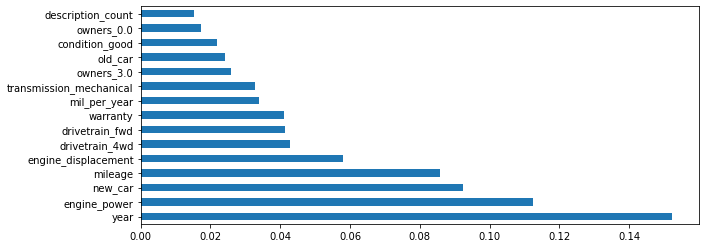

In [151]:
# По топ наиболее влияющим фичам все ожидаемо с обывательской точки зрения.
# Интересно, что есть много фич, добавленных в ходе Feature Engineeering'а
fig, ax = plt.subplots(figsize=(10, 4))
fig.patch.set_facecolor("xkcd:white")
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind="barh", ax=ax)


In [152]:
# MAPE почти не поменялась
y_lb = np.exp(model.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_03.csv", index=False)
# Kaggle: 12.69211
# результат получился даже чуть хуже, чем на параметрах по умолчанию (12.41811)

## CatBoost

In [153]:
# разделяем датасет для catboost
X_catboost = df_catboost.loc[df_catboost.data_type != 0, :].copy()
X_catboost.drop(["price", "data_type"], axis=1, inplace=True)

y_catboost = df_catboost.loc[df_catboost.data_type != 0, "price"].copy()

X_catboost_lb = df_catboost.loc[df_catboost.data_type == 0, :].copy()
X_catboost_lb.drop(["price", "data_type"], axis=1, inplace=True)

# разделям на тренировочную и тестовую выборки
X_catboost_train, X_catboost_test, y_catboost_train, y_catboost_test = train_test_split(
    X_catboost, y_catboost, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED
)

In [154]:
# попробуем сначала без логарифма
model = CatBoostRegressor(
    iterations=2000,
    learning_rate = 0.1,
    random_seed=RANDOM_SEED,
    eval_metric="MAPE",
    custom_metric=["R2", "MAE"],
    silent=True,
)
model.fit(
    X_catboost_train,
    y_catboost_train,
    eval_set=(X_catboost_test, y_catboost_test),
    verbose_eval=500,
    use_best_model=True,
    plot=False,
    cat_features=list(df_catboost.select_dtypes(include=["object"]).columns)
)

predict_catboost = model.predict(X_catboost_test)
print(f"MAPE: {(mape(y_catboost_test, predict_catboost) * 100):0.2f}%")
# MAPE: 10.44%
# Время: 3 мин

0:	learn: 2.0802837	test: 2.0600175	best: 2.0600175 (0)	total: 225ms	remaining: 7m 30s
500:	learn: 0.1328843	test: 0.1302183	best: 0.1302183 (500)	total: 41.3s	remaining: 2m 3s
1000:	learn: 0.1171265	test: 0.1158091	best: 0.1158091 (1000)	total: 1m 24s	remaining: 1m 24s
1500:	learn: 0.1084487	test: 0.1084620	best: 0.1084620 (1500)	total: 2m 5s	remaining: 41.6s
1999:	learn: 0.1029890	test: 0.1043994	best: 0.1043994 (1999)	total: 2m 45s	remaining: 0us

bestTest = 0.1043994193
bestIteration = 1999

MAPE: 10.44%


In [155]:
# MAPE получилась хуже, чем с RandomForest, тепер с логарифмом

cat_boost = CatBoostRegressor(
    iterations=2000,
    learning_rate = 0.1,
    random_seed=RANDOM_SEED,
    eval_metric="MAPE",
    custom_metric=["R2", "MAE"],
)
cat_boost.fit(
    X_catboost_train,
    np.log(y_catboost_train + 1),
    eval_set=(X_catboost_test, np.log(y_catboost_test+1)),
    verbose_eval=500,
    use_best_model=True,
    plot=False,
    cat_features=list(df_catboost.select_dtypes(include=["object"]).columns)
)

predict_catboost = np.exp(cat_boost.predict(X_catboost_test)) - 1
print(f"MAPE: {(mape(y_catboost_test, predict_catboost) * 100):0.2f}%")
# MAPE: 8.40%
# Время: 3 мин

0:	learn: 0.0568287	test: 0.0566990	best: 0.0566990 (0)	total: 90.5ms	remaining: 3m
500:	learn: 0.0071866	test: 0.0071596	best: 0.0071596 (500)	total: 38.1s	remaining: 1m 54s
1000:	learn: 0.0064302	test: 0.0065634	best: 0.0065634 (1000)	total: 1m 18s	remaining: 1m 17s
1500:	learn: 0.0060564	test: 0.0063241	best: 0.0063241 (1500)	total: 1m 58s	remaining: 39.5s
1999:	learn: 0.0058007	test: 0.0061879	best: 0.0061879 (1999)	total: 2m 38s	remaining: 0us

bestTest = 0.006187943912
bestIteration = 1999

MAPE: 8.40%


In [156]:
# МАРЕ стала лучше. Попробуем засабмитить вариант с логарифмом
y_lb = np.exp(cat_boost.predict(X_catboost_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_04.csv", index=False)
# результат 13.90262, хуже, чем на параметрах по умолчанию для RandomForest (12.41811)

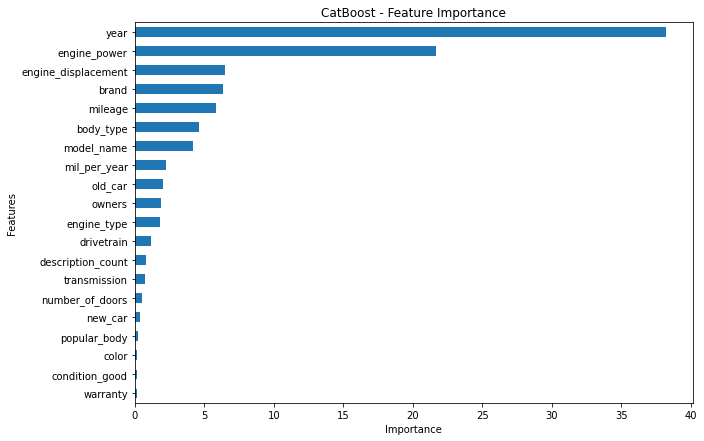

In [157]:
# посмотрим на влияние каждого параметра на целевую переменную
fig, ax = plt.subplots(figsize=(10, 7))
fig.patch.set_facecolor("xkcd:white")
feature_imp = pd.DataFrame({"imp": cat_boost.feature_importances_, "col": X_catboost.columns})
feature_imp = feature_imp.sort_values(["imp", "col"], ascending=[True, False]).iloc[-20:]
feature_imp.plot(kind="barh", x="col", y="imp", legend=None, ax=ax)
plt.title("CatBoost - Feature Importance")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()

In [158]:
# видно, что наиболее влияющие на цену параметры это год/мощность двигателя, а искусственно созданные нами
# колонки warranty/popular_body и пр не оказывают сильного влияния

## DecisionTreeRegressor

In [159]:
# без логарифма
model = DecisionTreeRegressor(
    random_state=RANDOM_SEED,
)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 11.15%
# Время 4 сек

MAPE: 11.15%


In [160]:
# с логарифмом
model = DecisionTreeRegressor(
    random_state=RANDOM_SEED,
)
model.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(model.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 11.14%
# Время: 3 сек

MAPE: 11.14%


In [161]:
# Разницы в МАРЕ никакой, как и в прошлых моделях пробуем засабмитить вариант с логарифмом
y_lb = np.exp(model.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_05.csv", index=False)
# результат 16.18319, пока самый худший результат, но зато считается раз в 10 быстрее чем RandomForest

## AdaBoostRegressor

In [162]:
# Попробуем применит Ada Boost к RandomForest с параметрами по-умолчанию
ada = AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
    random_state=RANDOM_SEED,
    n_estimators=10,
    loss="exponential",
    learning_rate=0.5,
)
ada.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(ada.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 7.67%
# Время: 7.5 мин

MAPE: 7.67%


In [163]:
# # Дало МАРЕ такое же, как и RandomForest (7.68 было)
# # попробуем найти оптимальные параметры с GridSearchCV, параметры в итоге подбирал вручную, так как своих ресурсов на
# # полноценный *SearchCV не хватает. Google colab так же не помог, постоянно вылетал из-за нехватки памяти.

# n_estimators = [2, 4, 10]
# loss = ["linear", "square"]
# learning_rate = [0.2, 0.4, 1.0]
# param_grid = {
#     "n_estimators": n_estimators,
#     "loss": loss,
#     "learning_rate": learning_rate,
# }
# ada_grid = GridSearchCV(
#     estimator=AdaBoostRegressor(
#         base_estimator=RandomForestRegressor(
#             random_state=RANDOM_SEED,
#             n_jobs=-1,
#         ),
#         random_state=RANDOM_SEED,
#     ),
#     param_grid=param_grid,
#     n_jobs=-1,
#     verbose=2,
#     cv=3,
# )
# ada_grid.fit(X_train, np.log(y_train + 1))


In [164]:
# # получили некоторые параметры
# # {'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 10}
# ada_grid.best_params_

фактически, параметры для AdaBoost подбирал вручную, рандомно выбирая комбинацию. Как отметил выше, ресурсов нехватило на автоматический поиск. В итоге получилось следующее
| n_estimators | loss | learning_rate | time to execute | MAPE |
| :----------: | :--: | :-----------: | :-------------: | :--: |
| 10 | exponential | 0.5 | 8 min | 7.67 |
| 10 | square | 0.5 | 8 min | 7.79 |
| 25 | exponential | 0.5 | 23 min | 7.59 |
| 25 | square | 0.5 | 19 min | 7.64 |
| 25 | linear | 0.5 | 19 min | 7.58 |
| 50 | exponential | 0.5 | 42 min | 7.58 |
| 100 | exponential | 0.5 | 64 min | 7.64 |
| 100 | exponential | 0.3 | 75 min | 7.59 |
| 150 | exponential | 0.2 | 98 min | 7.58 |
| 150 | linear | 0.2 | 99 min | 7.59 |


In [165]:
# В итоге останавливаемся на следующих параметрах
ada = AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
    random_state=RANDOM_SEED,
    n_estimators=150,
    loss="exponential",
    learning_rate=0.2,
)
ada.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(ada.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 7.58%
# Время: 100 мин

MAPE: 7.58%


In [166]:
# пока самое лучшее МАРЕ, но 100 минут на обучение трбует
y_lb = np.exp(ada.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_07.csv", index=False)
# Kaggle: 11.70037

In [167]:
# мы отделяли датафрейм с equipment колонкой, попробуем его вернуть обратно и сделать ada boost c общим датасетом
df_full = pd.concat([df, df_equipment], axis=1)

# X для нового датасета нужно сделать новые, y будет без изменений
X_full = df_full.loc[df_full.data_type != 0, :].copy()
X_full.drop(["price", "data_type"], axis=1, inplace=True)

X_full_lb = df_full.loc[df_full.data_type == 0, :].copy()
X_full_lb.drop(["price", "data_type"], axis=1, inplace=True)

# разделям на тренировочную и тестовую выборки
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED
)

In [168]:
# сначала проверим на "быстрых" паретрах
ada = AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
    random_state=RANDOM_SEED,
    n_estimators=10,
    loss="exponential",
    learning_rate=0.5,
)
ada.fit(X_full_train, np.log(y_full_train + 1))
y_predict = np.exp(ada.predict(X_full_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# параметр | было | стало с расширенным датсетов
# ---------|------|--------
#     MAPE | 7.67 | 7.58
#    время | 8min | 29min
# В итоге MAPE улучшилось, но и время значительно возрасло
# MAPE: 7.58%

MAPE: 7.58%


In [169]:
# # запустим на пареметрах, при которых получили лучший результат на лидер борде
# ada = AdaBoostRegressor(
#     base_estimator=RandomForestRegressor(
#         random_state=RANDOM_SEED,
#         n_jobs=-1,
#     ),
#     random_state=RANDOM_SEED,
#     n_estimators=150,
#     loss="exponential",
#     learning_rate=0.2,
# )
# ada.fit(X_full_train, np.log(y_train + 1))
# y_predict = np.exp(ada.predict(X_full_test)) - 1
# print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# # MAPE: 7.42%
# # Время: 400 мин

In [170]:
# # на полном датасете МАРЕ пока самая лучшая, но время на обучение 400минут
# # засабмитим на лидер борд
# y_lb = np.exp(ada.predict(X_full_lb)) - 1
# y_lb = y_lb.round()
# sample_submission["price"] = y_lb
# sample_submission.to_csv("./submission_final_08.csv", index=False)
# # результат 11.88808, что чуть хуже, чем да датасете без equipment. Но времени в разы больше нужно

## ExtraTreesRegressor

In [171]:
# начнем c параметрами по-умолчанию
model = ExtraTreesRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
model.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(model.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 7.62%
# Время: 50 сек

MAPE: 7.62%


In [172]:
# увеличим число деревьев
model = ExtraTreesRegressor(
    random_state=RANDOM_SEED,
    n_estimators=300,
    bootstrap=True,
    n_jobs=-1,
)
model.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(model.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 7.39%
# Время: 2 мин

MAPE: 7.39%


In [173]:
# засабмитим на лидер борд
y_lb = np.exp(model.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_09.csv", index=False)
# Kaggle: 12.37975

## XGBoost

In [174]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    colsample_bytree=0.5,
    learning_rate=0.05,
    max_depth=15,
    alpha=1,
    n_estimators=500,
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

model.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(model.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# МАРЕ: 7.46
# Время: 11 мин

MAPE: 7.46%


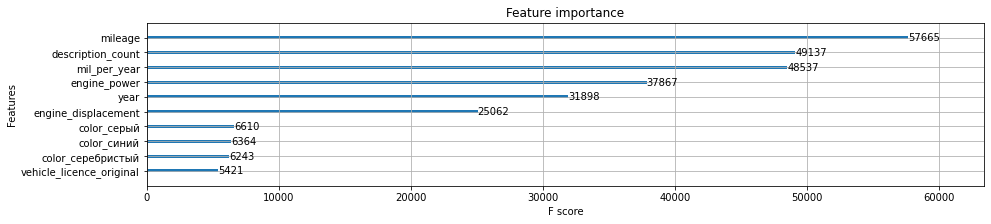

In [175]:
# топ-10 влиятельных фич. не совсем ожидаемая картина, например количество слов в описании или цвет
fig, ax = plt.subplots(figsize=(15, 3))
fig.patch.set_facecolor("xkcd:white")
xgb.plot_importance(model, max_num_features=10, ax=ax)
plt.show()

In [176]:
# засабмитим на лидер борд
y_lb = np.exp(model.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_10.csv", index=False)
# Kaggle: 12.71385

## StackingRegressor

In [177]:
estimators = [
    (
        "rfr",
        RandomForestRegressor(
            random_state=RANDOM_SEED,
            n_jobs=-1,
        ),
    ),
    (
        "etr",
        ExtraTreesRegressor(
            random_state=RANDOM_SEED,
            n_estimators=300,
            bootstrap=True,
            n_jobs=-1,
        ),
    ),
    (
        "xgb",
        xgb.XGBRegressor(
            objective="reg:squarederror",
            colsample_bytree=0.5,
            learning_rate=0.05,
            max_depth=15,
            alpha=1,
            n_estimators=500,
            random_state=RANDOM_SEED,
            n_jobs=-1,            
        ),
    ),
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1,
)

stack.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(stack.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 7.23%
# Время: 35 мин


MAPE: 7.23%


In [178]:
# засабмитим на лидер борд
y_lb = np.exp(stack.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_11.csv", index=False)
# Kaggle: 12.19727

## Коэффициент цены
Предыдущие предсказания мы делали на объедененном датасете (с baseline и найденном на кагле). Попробуем, по возможности, более точно поправить коэффицент цены, а так же сделать предсказания на основе только одного датасета.

In [179]:
# с кагла, data_type = 2, тренировочный
X_train = df.loc[df.data_type == 2, :].copy()
X_train.drop(["price", "data_type"], axis=1, inplace=True)

y_train = df.loc[df.data_type == 2, "price"].copy()

# с baseline, data_type = 1, тестовый
X_test = df.loc[df.data_type == 1, :].copy()
X_test.drop(["price", "data_type"], axis=1, inplace=True)

y_test = df.loc[df.data_type == 1, "price"].copy()


In [180]:
# пробовать будем используя RandomForestRegressor с параметрами по-умолчанию
# считалось быстро и результат был не сильно хуже лучшего
model = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
model.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(model.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 28.15%
# Время: 20 сек
# получается, что ошибка при обучении на датасете с кагла и предсказания цены для датасета из baseline
# составляет почти 30%, что очень много

MAPE: 28.15%


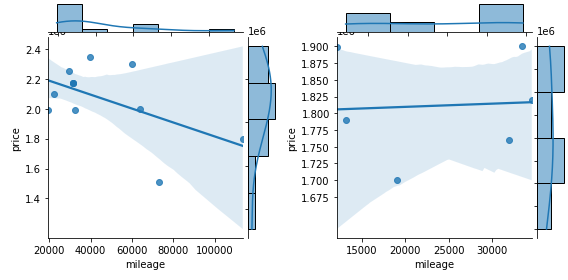

In [181]:
# возьмем на выбор пару моделей и посмотрим, что с ценой в каждом из датасетов
jp1 = sns.jointplot(
    x="mileage",
    y="price",
    kind="reg",
    data=train_extra[
        # (train_extra.model_name=="Qashqai")
        (train_extra.model_name == "X-Trail")
        & (train_extra.modelDate == 2017)
        & (train_extra.enginePower == "144 N12")
        & (train_extra.productionDate == 2019)
        & (train_extra["Владельцы"] == "1 владелец")
        & (train_extra["Привод"] == "полный")
        & (train_extra.mileage != 0)
        & (train_extra["Состояние"] == "Не требует ремонта")
        & (train_extra.vehicleTransmission == "вариатор")
    ][["mileage", "price"]],
)

jp2 = sns.jointplot(
    x="mileage",
    y="price",
    kind="reg",
    data=train_basic[
        # (train_basic.model_name=="QASHQAI")
        (train_basic.model_name == "X_TRAIL")
        & (train_basic.enginePower == 144)
        & (train_basic.productionDate == 2019)
        & (train_basic["Владельцы"] == 1)
        & (train_basic["Привод"] == "полный")
        & (train_basic.mileage != 0)
        & (train_basic.vehicleTransmission == "VARIATOR")
        & (train_basic.modelDate == 2017)
    ],
)

fig = plt.figure(figsize=(8, 4))
fig.patch.set_facecolor("xkcd:white")
gs = gridspec.GridSpec(1, 2)

mg0 = SeabornFig2Grid(jp1, fig, gs[0])
mg1 = SeabornFig2Grid(jp2, fig, gs[1])

gs.tight_layout(fig)


In [182]:
# странно, что цена на одном графике идет вверх при увеличении пробега, возможно дело в разных комплектациях авто в выборке
# или есть битые авто, мы не фильтровали это, в итоге для двух моделей нисана получилось следующее
# (оценка "на глаз" по среднему значению цены для примерно одинакогового пробега)
#  - 1650 т.р. против 1950 т.р. для qashqai
#  - 1800 т.р. против 2100 т.р. для x-trail
# модели выбирал случайно, что бы просто посмотреть, как менялась цена. В обоих случаях изменение около 14-15%
# а не 20% как изначально заложили

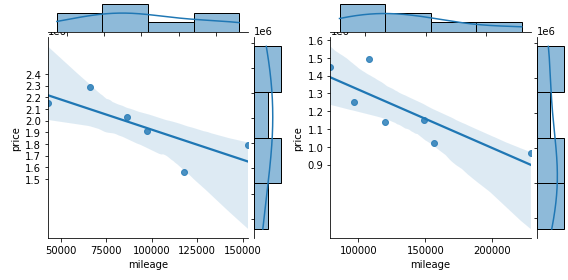

In [183]:
# посмотрим тоже самое для вольво
jp1 = sns.jointplot(
    x="mileage",
    y="price",
    kind="reg",
    data=train_extra[
        (train_extra.brand == "VOLVO")
        & (train_extra.model_name == "XC60")
        & (train_extra.enginePower == "181 N12")
        & (train_extra.productionDate == 2014)
        & (train_extra["Владельцы"] == "1 владелец")
        & (train_extra["Привод"] == "полный")
        & (train_extra.mileage != 0)
        & (train_extra.vehicleTransmission == "автоматическая")
    ][["mileage", "price"]],
)

jp2 = sns.jointplot(
    x="mileage",
    y="price",
    kind="reg",
    data=train_basic[
        (train_basic.brand == "VOLVO")
        & (train_basic.model_name == "XC60")
        & (train_basic.enginePower == 163)
        & (train_basic.productionDate == 2012)
        & (train_basic["Владельцы"] == 1)
        & (train_basic["Привод"] == "полный")
        & (train_basic.vehicleTransmission == "AUTOMATIC")
        & (train_basic.mileage != 0)
    ][["mileage", "price"]],
)

fig = plt.figure(figsize=(8, 4))
fig.patch.set_facecolor("xkcd:white")
gs = gridspec.GridSpec(1, 2)

mg0 = SeabornFig2Grid(jp1, fig, gs[0])
mg1 = SeabornFig2Grid(jp2, fig, gs[1])

gs.tight_layout(fig)

In [184]:
# по volvo xc60, при примерно одинаковых параметрах авто, получилось следующее
# 1900 против 1350 при 100000 км пробега, получается рост около 40% (но из train_basic брались 8ми летние машины,
# а из train_extra - 7ми летние), но все равно рост большой, что что еще раз подтверждает,
# что разные модели/брэнды дорожали по-разному.

In [185]:
# уменьшим цену датасета от 2021 года еще на 10% и посмотрим MAPE для предсказания цены для датасета 2020 года
# затем попробуем по брендам вычислить среднее подорожание и сделать корректировку по каждому бренду отдельно
#
# RandomForestRegressor с параметрами по-умолчанию
model = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
model.fit(X_train, np.log(y_train * 0.9 + 1))
y_predict = np.exp(model.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 25.03%
# Время: 20 сек

MAPE: 25.03%


In [186]:
# получось лучше чем было (28.15%), но все равно большая ошибка. Сабмитить не будем.
# Посмотрим, что будет если на лидер борд сабмитить данные, полученные при обучении на датасетах разных годов по отдельности
# Делить каждый датасет на трининровочные/валидационные и считать МАРЕ уже не будем.
# используем все данные для обучения и сразу заливаем результат на кагл.

# Датасет от 2021 года (с кагла) с доп. коррекцией цены 0.9
ada = AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
    random_state=RANDOM_SEED,
    n_estimators=150,
    loss="exponential",
    learning_rate=0.2,
)
ada.fit(X_train, np.log(y_train * 0.9 + 1))

y_lb = np.exp(ada.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_12.csv", index=False)
# Время: 53 мин
# Kaggle: 19.27023

In [187]:
# Датасет от 2020 года (base line)
ada = AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
    random_state=RANDOM_SEED,
    n_estimators=150,
    loss="exponential",
    learning_rate=0.2,
)
ada.fit(X_test, np.log(y_test + 1))

y_lb = np.exp(ada.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_13.csv", index=False)
# Время: 55 мин
# Kaggle: 10.69384
# получился лучший из всех ранее полученных результатов,

In [188]:
# Попробуем датасет от 2021 года (с кагла) с доп. коррекцией цены 1.06
ada = AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
    random_state=RANDOM_SEED,
    n_estimators=150,
    loss="exponential",
    learning_rate=0.2,
)
ada.fit(X_train, np.log(y_train * 1.06 + 1))

y_lb = np.exp(ada.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_14.csv", index=False)
# Время: 64 мин
# Kaggle: 15.90357
# лучше чем с корректировкой в 0.9, но все равно плохо

## Второй подход
Промежуточный вывод такой, что цена в датасете от 2021 нуждается в коррекции с более сложной логикой, чем "уменьшаем все на Х%". Так же, возможно, что поменялся срез рынка и это оказывает сильное вляиние на обучение, например в 2020 году было больше машин среднего класса, а в 2021 стало больше премиум сегмента.
Последний вариант, который попробуем сделать с выборкой:
- проверим и удалим из обучающего датасетов модели авто, которых нет в тестовом
- сделаем коэффициент правки цены на основе каждой модели
- в тестовом датасете нет новых машин, а в датасете от 2021 есть, поэтому удалим их, так как их цена может сильно влиять на обучение

In [189]:
# восстанавливаем наш df из файла, что бы не повторять всю предобработку
df = pd.read_csv("./df.csv")

# делаем временную колонку вида <brand>_<model_name>, что бы вычистить отсутсвующие в тестовой выборке модели.
df["full_model"] = df.brand + "_" + df.model_name
df.drop(
    df[(df.data_type != 0) & ~(df[df.data_type != 0].full_model.isin(df[df.data_type == 0].full_model))].index,
    inplace=True,
)
df.drop(["full_model"], axis=1, inplace=True)

# удаляем новые машины (пробег=0) из датасета, и колонку "state_new" заодно, так как она больше не имеет смыла
df = df.drop(df[df.mileage == 0].index)
df.drop(["state_new"], axis=1, inplace=True)

# мы делали корректировку цены в датасете от 2021 года до сохранения в файл, поэтому восстановим оригинальное значение
df.loc[df.data_type == 2, "price"] = round(df.loc[df.data_type == 2, "price"] / PRICE_CORRECTION)


In [190]:
# делаем корректировку по цене для каждой модели
old = df[df.data_type == 1].groupby(["brand", "model_name"]).price.mean()
new = df[df.data_type == 2].groupby(["brand", "model_name"]).price.mean()

price_coef = old / new
price_coef.fillna(price_coef.mean(), inplace=True)
# на всякий случай ограничим коэффициент границами 0.7 ... 1.0
price_coef = price_coef.apply(lambda value: 0.7 if value < 0.7 else value)
price_coef = price_coef.apply(lambda value: 1.0 if value > 1.0 else value)
price_coef = price_coef.round(2)

df.loc[df.data_type == 2, "price"] = df.loc[df.data_type == 2].apply(
    lambda row: round(price_coef[row.brand][row.model_name] * row.price),
    axis=1,
)


In [191]:
# готовим датасет для обчения
scaler = MinMaxScaler()
for column in columns_num:
    scaled = scaler.fit_transform(df.loc[:, [column]])
    df[column] = scaled

encoder = BinaryEncoder(cols=["model_name"])
df_bin = encoder.fit_transform(df["model_name"])
df = pd.concat([df, df_bin], axis=1)
df.drop(["model_name"], axis=1, inplace=True)

df = pd.get_dummies(df, columns=columns_cat)

In [192]:
# разделяем датасет на тренировочный/валидационный и тестовый, и выделяем целевой параметр
X = df.loc[df.data_type != 0, :].copy()
X.drop(["price", "data_type"], axis=1, inplace=True)

y = df.loc[df.data_type != 0, "price"].copy()

X_lb = df.loc[df.data_type == 0, :].copy()
X_lb.drop(["price", "data_type"], axis=1, inplace=True)

# разделям на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [193]:
# Начнем с RandomForest с параметрами по-умолчанинию
model = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
model.fit(X_train, np.log(y_train + 1))
y_predict = np.exp(model.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")
# MAPE: 7.56%
# Время: 25 сек

MAPE: 7.56%


In [194]:
# MAPE почти не моменялась, посмотрим на лидер борде
y_lb = np.exp(model.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_16.csv", index=False)
# Kaggle: 15.05435

In [195]:
# попробуем AdaBoost
ada = AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
    random_state=RANDOM_SEED,
    n_estimators=150,
    loss="exponential",
    learning_rate=0.2,
)
ada.fit(X_train, np.log(y_train + 1))

y_predict = np.exp(ada.predict(X_test)) - 1
print(f"MAPE: {(mape(y_test, y_predict) * 100):0.2f}%")

y_lb = np.exp(ada.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_17.csv", index=False)
# MAPE: 7.38
# Время: 54 min
# Kaggle: 14.33915

MAPE: 7.38%


МАРЕ в итоге получилась хорошая, но на Kaggle результат сильно ухудшился. Возможно модель переобучатся.

## Датасет из baseline
Результаты не очень хорошие. В итоге лучший результат дал датасет из baseline.
Попробуем еще раз с ним поработать: удалим несуществующие модели и дубликаты


### Подготовка

In [196]:
# восстанавливаем наш df из файла, что бы не повторять всю предобработку
df = pd.read_csv("./df.csv")
df = df.drop(df[df.data_type == 2].index)

# делаем временную колонку вида <brand>_<model_name>, что бы вычистить отсутсвующие в тестовой выборке модели.
df["full_model"] = df.brand + "_" + df.model_name
df.drop(
    df[(df.data_type != 0) & ~(df[df.data_type != 0].full_model.isin(df[df.data_type == 0].full_model))].index,
    inplace=True,
)
df.drop(["full_model"], axis=1, inplace=True)

# удаляем новые машины (пробег=0) из датасета, и колонку "state_new" заодно, так как больше не имеет смыла
df = df.drop(df[df.mileage == 0].index)
df.drop(["state_new"], axis=1, inplace=True)


In [197]:
# удалим дубликаты
df.loc[df.data_type == 1, :] = df.loc[df.data_type == 1, :].drop_duplicates()
df.dropna(inplace=True)

In [198]:
# columns_num.remove("description_count_log")
# columns_num.remove("model_date")
# columns_cat.remove("model_name")

In [199]:
# готовим датасет для обчения
scaler = MinMaxScaler()
for column in columns_num:
    scaled = scaler.fit_transform(df.loc[:, [column]])
    df[column] = scaled

encoder = BinaryEncoder(cols=["model_name"])
df_bin = encoder.fit_transform(df["model_name"])
df = pd.concat([df, df_bin], axis=1)
df.drop(["model_name"], axis=1, inplace=True)

df = pd.get_dummies(df, columns=columns_cat)

In [200]:
# разделяем датасет на тренировочный и тестовый, и выделяем целевой параметр
# выделять валидационный не будем. сделаем KFold валидацию, или сразу будем
# сабмитить на kaggle
X = df.loc[df.data_type != 0, :].copy()
X.drop(["price", "data_type"], axis=1, inplace=True)

y = df.loc[df.data_type != 0, "price"].copy()

X_lb = df.loc[df.data_type == 0, :].copy()
X_lb.drop(["price", "data_type"], axis=1, inplace=True)


### KFold
Оценим МАРЕ для ExtraTreesRegressor с параметрами по умолчанию

In [201]:
# сделаем KFold валидацию для ExtraTrees
# Результат средний, но посмотрим дальше

model = ExtraTreesRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
)

mape_values = kfold_validate(model, X, y)
print(f"mean MAPE: {(mape_values[-1] * 100):0.2f}%")
# MAPE: 15.21%
# Время: 23 сек

mean MAPE: 15.21%


### AdaBoost + ExtraTrees + параметры из RandomizedSearchCV

In [202]:
# попробуем найти оптимальные параметры с RandomizedSearchCV
n_estimators = [100, 200, 500, 1000]
max_depth = [5, 10, 20, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ["auto", "sqrt"]
bootstrap = [True, False]
random_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "max_features": max_features,
    "bootstrap": bootstrap,
}
model = ExtraTreesRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
etr_random = RandomizedSearchCV(
    estimator=model,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
etr_random.fit(X, np.log(y + 1))

# Результат
# {'n_estimators': 200,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_features': 'auto',
#  'max_depth': 20,
#  'bootstrap': True}

RandomizedSearchCV(cv=3,
                   estimator=ExtraTreesRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 20, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42)

In [203]:
params = {
    "n_estimators": 200,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "max_features": "auto",
    "max_depth": 20,
    "bootstrap": True,
}
model = ExtraTreesRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
    **params,
)
mape_values = kfold_validate(model, X, y)
print(f"MAPE: {(mape_values[-1] * 100):0.2f}%")

# MAPE: 14.51%
# Время: 26 сек

MAPE: 14.51%


In [204]:
# и наконец сделаем AdaBoost c указанной моделью и засабмитим, параметры модели берем те, что получились
# в RandomizedSearchCV, а для AdaBoost из основного блока про AdaBoost
model = AdaBoostRegressor(
    base_estimator=ExtraTreesRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
        **params,
    ),
    random_state=RANDOM_SEED,
    n_estimators=150,
    loss="exponential",
    learning_rate=0.2,
)

model.fit(X, np.log(y + 1))

y_lb = np.exp(model.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_19.csv", index=False)
# Время: 18 min
# Kaggle: 10.79597
# результат чуть хуже, чем дал AdaBoost c RandomForest (10.69384)
# Попробуем его еще раз (датасет у нас чуть изменился, убрали дубликаты и новые машины)

### AdaBoost + RandomForest

In [205]:
# Датасет от 2020 года (base line) но без дубликатов и новых машин
model = AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
    ),
    random_state=RANDOM_SEED,
    n_estimators=150,
    loss="exponential",
    learning_rate=0.2,
)
model.fit(X, np.log(y + 1))

y_lb = np.exp(model.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_20.csv", index=False)
# Kaggle: 10.53045
# Время: 19 мин


### AdaBoost + RandomForest + параметры из RandomizedSearchCV

In [206]:
# попробуем найти оптимальные параметры с RandomizedSearchCV
n_estimators = [100, 200, 500, 1000]
max_depth = [5, 10, 20, None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = ["auto", "sqrt"]
bootstrap = [True, False]
random_grid = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "max_features": max_features,
    "bootstrap": bootstrap,
}
model = RandomForestRegressor(
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
rfr_random = RandomizedSearchCV(
    estimator=model,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    random_state=RANDOM_SEED,
    n_jobs=-1,
)
rfr_random.fit(X, np.log(y + 1))

# Время: 41 мин
# Результат:
# {'n_estimators': 1000,
#  'min_samples_split': 5,
#  'min_samples_leaf': 2,
#  'max_features': 'auto',
#  'max_depth': 20,
#  'bootstrap': True}


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 20, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42)

In [207]:
params_rf = {
    # "n_estimators": 1000,
    "n_estimators": 500,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "max_features": "auto",
    "max_depth": 20,
    "bootstrap": True,
}

model = AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
        random_state=RANDOM_SEED,
        n_jobs=-1,
        **params_rf,
    ),
    random_state=RANDOM_SEED,
    n_estimators=150,
    loss="exponential",
    learning_rate=0.2,
)
model.fit(X, np.log(y + 1))

y_lb = np.exp(model.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_21.csv", index=False)
# Kaggle: 11.18786
# Время: 82 мин


### Stacking (RandomForest + ExtraTrees XGBRegressor)

In [ ]:
# Попробуем стеккинг:
estimators = [
    (
        "rfr",
        RandomForestRegressor(
            random_state=RANDOM_SEED,
            n_jobs=-1,
        ),
    ),
    (
        "etr",
        ExtraTreesRegressor(
            random_state=RANDOM_SEED,
            n_jobs=-1,
        ),
    ),
    (
        "XGB",
        xgb.XGBRegressor(
            objective="reg:squarederror",
            colsample_bytree=0.5,
            learning_rate=0.05,
            max_depth=15,
            alpha=1,
            n_estimators=500,
            random_state=RANDOM_SEED,
            n_jobs=-1,            
        ),
    ),
]

model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=4,
    n_jobs=-1,
)

model.fit(X, np.log(y + 1))

y_lb = np.exp(model.predict(X_lb)) - 1
y_lb = y_lb.round()
sample_submission["price"] = y_lb
sample_submission.to_csv("./submission_final_24.csv", index=False)
# Kaggle: 10.58144
# Время: 6 мин


# Итоговая таблица

| Алгоритм | Время обучения | МАРЕ | LeaderBord | Коментарий |
| :------- | :------------: | :--: | :--------: | :--------- |
| RandomForestRegressor | 40 сек | 8.49 | 13.20330 | параметры по-умолчанию, price не логарифмированный |
| RandomForestRegressor | 40 сек | 7.8 | 12.41811 | параметры по-умолчанию |
| RandomForestRegressor | 1.5 мин | 7.68 | 12.69211 | подобранные через RandomizedSearchCV параметры |
| СatBoost | 3 мин | 8.40 | 13.90262 | |
| DecisionTreeRegressor | 3 сек | 11.14 | 16.18319 | |
| AdaBoostRegressor (RandomForest) | 100 мин | 7.58 | 11.70037 | |
| AdaBoostRegressor (RandomForest) | 400 мин | 7.42 | 11.88808 | датасет с equipment |
| ExtraTreesRegressor | 3 мин | 7.39 | 12.37975 | |
| XGBRegressor | 11 мин | 7.46 | 12.71385 | |
| StackingRegressor (RandomForest + ExtraTrees + XGBRegressor) | 35 min | 7.23 | 12.19727 |
| AdaBoostRegressor (RandomForest) | 53 min | n/a | 19.27023 | датасет от 2021 года с доп. коррекцией цены 0.9 |
| AdaBoostRegressor (RandomForest) | 55 min | n/a | 10.69384 | датасет от 2020 года (с baseline) |
| AdaBoostRegressor (RandomForest) | 64 min | n/a | 15.90357 | датасет от 2021 года с доп. коррекцией цены 1.06 |
| AdaBoostRegressor (RandomForest) | 23 min | n/a | 11.42821 | датасет от 2020 года, с удаленными моделями, которых нет в датасете для сабмита |
| RandomForestRegressor | 20 sec | 7.56 | 15.05435 | параметры по-умолчанию, датасет без новых машин и c корректировкой цены для каждой модели |
| AdaBoostRegressor (RandomForest) | 55 min | 7.38 | 14.33915 | датасет без новых машин и c корректировкой цены для каждой модели |
| AdaBoostRegressor (ExtraTreesRegressor) | 18 min | n/a | 10.79597 | только датасет с baseline и без новых машин |
| AdaBoostRegressor (RandomForest) | 19 min | n/a | 10.53045 | только датасет с baseline и без новых машин |
| AdaBoostRegressor (RandomForest) | 82 min | n/a | 11.18786 | только датасет с baseline и без новых машин параметры RandomForest из SearchCV |
| StackingRegressor (RandomForest + ExtraTrees + XGBRegressor) | 6 min | n/a | 10.58144 | только датасет с baseline и без новых машин |


# Выводы
- лучшая МАРЕ (7.23) получилась на StackingRegressor (RandomForest + ExtraTrees + XGBRegressor), но при этом на Kaggle результат далеко нне лучший.
- есть ситуации, когда МАРЕ получается хорошая, но на Kaggle результат очень плохой. Возможно модель переобучается.
- править цену свежих датасетов нужно более "ителлектуально", чем просто умножить все на X.
- во всех случаях AbaBoost давал лучший результат, но время на обучение модели при этом увеличивается на порядок.
- наиболее оптимальный выбор, с моей точки зрения, это StackingRegressor, приемлемый результат и не нужнно ждать часы на обученине.
- ресурсов на GridSearchCV точно не хватает, RandomSearchCV работает через раз, ядро часто падает из-за нехватки памяти.
- лучший результат на Kaggle 10.52269, был получен с AdaBoost (RandomForest), но ячейка с параметрами была случайно удалена, следующиий результат 10.53045 так же получен с AdaBoost (RandomForest)

## Нериализованные идеи
- в выборке (тестовой и из baseline) присутсвуют раритные и просто старые авто, цена на которые может быть сильно зависеть от конкретной ситуации и не поддаваться прогнозу в принципе. Хотел выделить хотя бы раритетные авто в отдельнный датасет, что бы они не были выбросами, и делать прогнозы отдельно, затем склеивать.
- более интелектуально парсить описание, например с целью понять комплектацию или битое/нет авто, просто подсчет числа слов мало что может дать.